In [464]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score,precision_score, recall_score, f1_score, r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor

In [465]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

Dados atualizados em 22/02/2024

In [497]:
tbl_dam = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_dam_debito_22_02.csv'
tbl_historico_contribuinte = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_historico_contribuinte_db_22_02.csv'

In [498]:
df_dam = pd.read_csv(tbl_dam, encoding='utf-8')
df_historico_contribuinte = pd.read_csv(tbl_historico_contribuinte, encoding='utf-8')

In [499]:
grandes_numeros = df_dam.groupby(['ano_fato_gerador']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'dam': 'nunique',
    'id_imovel': 'nunique',
    'id_contribuinte': 'nunique'
}).reset_index()

grandes_numeros['vlr_lancado'] = (grandes_numeros['vlr_aberto'] + grandes_numeros['vlr_pago']).apply(formatar_moeda)
grandes_numeros['vlr_aberto'] = grandes_numeros['vlr_aberto'].apply(formatar_moeda)
grandes_numeros['vlr_pago'] = grandes_numeros['vlr_pago'].apply(formatar_moeda)
grandes_numeros

,ano_fato_gerador,vlr_aberto,vlr_pago,dam,id_imovel,id_contribuinte,vlr_lancado
0,2017.0,"R$ 41.660.359,80","R$ 560.159.751,54",255559,254531,163895,"R$ 601.820.111,34"
1,2018.0,"R$ 51.386.768,99","R$ 539.554.695,70",240406,240246,157012,"R$ 590.941.464,69"
2,2019.0,"R$ 41.628.522,46","R$ 660.991.573,44",265954,265739,169578,"R$ 702.620.095,90"
3,2020.0,"R$ 57.085.317,40","R$ 668.308.373,95",261290,261227,167266,"R$ 725.393.691,35"
4,2021.0,"R$ 33.233.849,33","R$ 700.184.389,90",257194,257120,164480,"R$ 733.418.239,23"
5,2022.0,"R$ 290.607.003,56","R$ 812.636.539,06",359364,359266,215759,"R$ 1.103.243.542,62"
6,2023.0,"R$ 295.809.144,12","R$ 857.074.255,29",365201,365113,218236,"R$ 1.152.883.399,41"
7,2024.0,"R$ 1.100.096.806,67","R$ 42.041.864,23",366293,366292,219024,"R$ 1.142.138.670,90"


## MANIPULAÇÃO DE DADOS DA DÍVIDA

In [500]:
df_dam.head()

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_acessorio_dam,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,39.0,2944.1,0.0,0.0,2944.1
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,39.0,2627.7,0.0,0.0,2627.7
2,000032f6d93a0abd,5c392b470f1f27a1295a294a15cb156f,71fc88ab6bbb201c344d77602867ec09,2024.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2024-01-01,0.0,39.0,0.0,1804.4,0.0,1804.4
3,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,39.0,3335.1,0.0,0.0,3335.1
4,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,39.0,3630.4,0.0,0.0,3630.4


In [501]:
contagem_imovel = df_dam.groupby('id_contribuinte')['id_imovel'].nunique()
registros_duplicados = df_dam[df_dam['id_contribuinte'].isin(contagem_imovel[contagem_imovel > 1].index)]
registros_duplicados.query('id_contribuinte == "4c375f5fe6f11e99cd124eb8021f7dca"')

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_acessorio_dam,vlr_total_dam
22,0000c599ab737fa1,35a5f340f67738f419002eec9f619408,4c375f5fe6f11e99cd124eb8021f7dca,2021.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2021-02-09,1.0,52.0,1112.60,0.00,0.00,1112.60
23,0000c599ab737fa1,491bd50714736f724c1f696350fff79e,4c375f5fe6f11e99cd124eb8021f7dca,2019.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2019-02-07,1.0,52.0,1055.40,0.00,0.00,1055.40
24,0000c599ab737fa1,52a09679bbf7a68690ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2023-12-19,0.0,52.0,0.00,1697.79,401.79,1697.79
25,0000c599ab737fa1,8360ed1065c0c9b611babe4a46e18b6d,4c375f5fe6f11e99cd124eb8021f7dca,2018.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2018-02-07,1.0,52.0,1014.70,0.00,0.00,1014.70
26,0000c599ab737fa1,8b7cc9eb1c4ce7c5e08920064611a7cf,4c375f5fe6f11e99cd124eb8021f7dca,2017.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2017-02-03,1.0,52.0,993.01,0.00,0.00,993.01
27,0000c599ab737fa1,bf7dabc23fbda539295a294a15cb156f,4c375f5fe6f11e99cd124eb8021f7dca,2024.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2024-01-01,0.0,52.0,0.00,1350.50,0.00,1350.50
28,0000c599ab737fa1,db7cb92fb806efc0875350beaddc7871,4c375f5fe6f11e99cd124eb8021f7dca,2022.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2022-01-31,1.0,52.0,1224.40,0.00,0.00,1224.40
29,0000c599ab737fa1,fbee00a70512c0e40ba9f03948490762,4c375f5fe6f11e99cd124eb8021f7dca,2020.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2020-02-07,1.0,52.0,1076.40,0.00,0.00,1076.40
402292,2b4e52aa40ed629d,56e1417b75d5110f295a294a15cb156f,4c375f5fe6f11e99cd124eb8021f7dca,2024.0,1,125.26,1,P,CASA,CONSTRUÍDA,ZUMBI,2008-12-11 19:06:14,2024-01-01,0.0,42.0,0.00,2865.40,0.00,2865.40
402293,2b4e52aa40ed629d,bb49f934732c9ea890ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.26,1,P,CASA,CONSTRUÍDA,ZUMBI,2008-12-11 19:06:14,2023-12-19,0.0,42.0,0.00,3591.50,850.30,3591.50


EURÍSTICA DE MANIPULAÇÃO DE DADOS ADOTADA
dam
ano_fato_gerador
id_imovel
idade_imovel 
vlr_aberto
vlr_pago
area_construida 
tipo_propriedade
bairro
natureza_imovel - tranforma p em 1 e t em 0
NOVA COLUNA chamada vlr_lançado = vlr_aberto + vlr_pago
NOVA COLUNA chamada aberto = se vlr_lançado = vlr_pago atribuir 1, se não atribuir 0

In [502]:
# dummizando a variavel de natureza de imóvel
mapeamento_natureza = {'P': 1, 'T': 0}
df_dam['natureza_imovel'] = df_dam['natureza_imovel'].map(mapeamento_natureza)

In [503]:
colunas_selecionadas = ['dam',  'id_imovel', 'id_contribuinte', 'ano_fato_gerador', 'natureza_imovel', 'idade_imovel', 'area_construida',
                      'tipo_propriedade', 'bairro', 'vlr_aberto', 'vlr_pago']

feature_dam = df_dam[colunas_selecionadas].copy()

feature_dam['vlr_lancado'] = feature_dam['vlr_aberto'] + feature_dam['vlr_pago']
feature_dam['aberto'] = (feature_dam['vlr_lancado'] != feature_dam['vlr_pago']).astype(int)
feature_dam

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0
2,5c392b470f1f27a1295a294a15cb156f,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2024.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,1804.4,0.00,1804.40,1
3,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0
4,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2385006,c0ff37bd120cc0d619002eec9f619408,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,568.39,568.39,0
2385007,c8d60514c5f4b18ee08920064611a7cf,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,503.20,503.20,0
2385008,d97d28d5be81653f295a294a15cb156f,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2024.0,1,42.0,89.15,APARTAMENTO,VARZEA,692.0,0.00,692.00,1
2385009,e46ab0c52787357611babe4a46e18b6d,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,515.10,515.10,0


In [504]:
df_dam_nulos = feature_dam[feature_dam['bairro'].isnull()]
df_dam_nulos.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
181022,28e87ba0e6079ed80ba9f03948490762,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2020.0,1,8.0,NaN,NaN,NaN,0.00,1260.20,1260.20,0
181023,4b65dd3735737b29e08920064611a7cf,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2017.0,1,8.0,NaN,NaN,NaN,1713.41,0.00,1713.41,1
181024,4f963eccb4677558295a294a15cb156f,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2024.0,1,8.0,NaN,NaN,NaN,1611.90,0.00,1611.90,1
181025,7fd0786f77af52324c1f696350fff79e,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2019.0,1,8.0,NaN,NaN,NaN,0.00,1240.02,1240.02,0
181026,9803a33efc9734c9875350beaddc7871,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2022.0,1,8.0,NaN,NaN,NaN,0.00,1447.40,1447.40,0


### TRATAMENTO DOS VALORES NULOS

In [505]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

# retirar os id_contribuinte nulos ou sem documento
# area_construida preencher com 0
# idade_imovel preencher com 0         
# tipo_propriedade preencher com 'TERRENO'  
# bairro preencher com 'DESCONHECIDO'

dam                      0
id_imovel                0
id_contribuinte     102224
ano_fato_gerador         0
natureza_imovel          0
idade_imovel         12144
area_construida      56961
tipo_propriedade     56961
bairro                  62
vlr_aberto               0
vlr_pago                 0
vlr_lancado              0
aberto                   0
dtype: int64

In [506]:
feature_dam = feature_dam.dropna(subset=['id_contribuinte']).copy()
feature_dam['area_construida'].fillna(0, inplace=True)
feature_dam['idade_imovel'].fillna(0, inplace=True)
feature_dam['tipo_propriedade'].fillna('TERRENO', inplace=True)
feature_dam['bairro'].fillna('DESCONHECIDO', inplace=True)


In [507]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

In [520]:
feature_dam = feature_dam.sort_values(by=['id_contribuinte', 'ano_fato_gerador'])
feature_dam['hist_dams'] = feature_dam.groupby('id_contribuinte').cumcount() + 1
feature_dam.query('id_contribuinte == "71fc88ab6bbb201c344d77602867ec09"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto,hist_dams
5,d22fdd2de1578b53e08920064611a7cf,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2017.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2459.37,2459.37,0,1
6,e6aebd3d9bee80d811babe4a46e18b6d,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2018.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2519.60,2519.60,0,2
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0,3
7,fedb8d299d9842480ba9f03948490762,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2020.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2764.50,2764.50,0,4
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0,5
3,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0,6
4,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0,7
2,5c392b470f1f27a1295a294a15cb156f,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2024.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,1804.4,0.00,1804.40,1,8


In [509]:
feature_dam.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto,hist_dams
238171,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2017.0,1,56.0,110.15,CASA,AREIAS,0.00,721.31,721.31,0,1
238172,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2022.0,1,56.0,110.15,CASA,AREIAS,1379.50,0.00,1379.50,1,2
238170,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2023.0,1,56.0,110.15,CASA,AREIAS,1238.96,0.00,1238.96,1,3
238173,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2024.0,1,56.0,110.15,CASA,AREIAS,986.40,0.00,986.40,1,4
1004106,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2017.0,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,1453.81,0,1


## MANIPULAÇÃO DE DADOS DO CONTRIBUINTE

In [510]:
df_historico_contribuinte.head()

,ano,id_contribuinte,tipo_pessoa,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
0,2013,00001a3e5b2177499daa7b7dbb545c1c,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,2013,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,2013,00003a695da4777aec557718ffae83ea,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,2013,000046c85d18a6f7968646cfc1e328f2,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0


In [479]:
df_historico_contribuinte.query('id_contribuinte == "0000398c485f8b42344d77602867ec09"')

,ano,id_contribuinte,tipo_pessoa,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
1,2013,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.00,0.00,0.00
252150,2014,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.00,0.00,0.00
504299,2015,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.00,0.00,0.00
756448,2016,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.00,0.00,0.00
1008597,2017,0000398c485f8b42344d77602867ec09,PF,0,0,0,1,1,0,0,1,0.00,721.31,721.31
1260746,2018,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.00,0.00,0.00
1512895,2019,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.00,0.00,0.00
1765044,2020,0000398c485f8b42344d77602867ec09,PF,0,1,0,0,0,0,0,0,0.00,0.00,0.00
2017193,2021,0000398c485f8b42344d77602867ec09,PF,0,1,0,0,0,0,0,0,0.00,0.00,0.00
2269342,2022,0000398c485f8b42344d77602867ec09,PF,1,1,0,0,1,0,1,1,1379.50,0.00,1379.50


EURÍSTICA ADOTADA PARA MANIPULAÇÃO DE DADOS

id_contribuinte
pgt_cota_unica
hist_pagamento
hist_valor_lançado
num_imoveis
reco_divida 
existe esta coluna reco_debito, eu calculei para esta coluna o valor contido em reco_debito + o valor contido em reco_divida sendo o total preenchido na coluna reco_debito
NOVA COLUNA reco_credito = a logica dessa coluna será a seguinte: será contar quantos id_contribuinte tem quando hist_valor_total for diferente de 0 em relação aos anos anteriores. exemplo: eu tenho na minha base o registo xxxx e eu tenho na base os anos entre 2013 e 2023 certo? quando for o registro de 2017 desse contribuinte xxxx eu vou realizar a logica olhando quantas vezes esse id_contribuinte apareceu até este ano em que o hist_valor_total foi diferente de 0 considerando tambem o ano atual, neste exemplo 2017 no caso, e assim cada ano eu terei a quantidade atualizada.

# Construção das variáveis de histórico e acumulativas ano a ano

In [511]:
feature_contribuinte = df_historico_contribuinte[['ano', 'id_contribuinte','reco_debito', 'pgt_cota_unica', 'hist_valor_pago', 'hist_valor_total', 'num_imoveis', 'reco_divida_ativa']].copy()
feature_contribuinte['hist_cota_unica'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

# Construindo variavel historico de pagamento e valor lançado do contribuinte
feature_contribuinte['hist_pagamento'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_pago'].cumsum()
feature_contribuinte['hist_lancado'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].cumsum()

# reco_debito
feature_contribuinte['reco_debito'] = feature_contribuinte['reco_debito'] + feature_contribuinte['reco_divida_ativa']

# reco_credito
feature_contribuinte['reco_credito'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].apply(lambda x: (x.shift(1) != 0).cumsum())
feature_contribuinte['reco_credito'] = np.where(feature_contribuinte['hist_valor_total'] == 0, 0, feature_contribuinte['reco_credito'])

feature_contribuinte


,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0.00,0.00,0,0,0,0.00,0.00,0
1,2013,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,0.00,0.00,0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0.00,0.00,0,0,0,0.00,0.00,0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0.00,0.00,0,0,0,0.00,0.00,0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0.00,0.00,0,0,0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2773634,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,645.20,645.20,1,0,0,3202.69,3789.56,7
2773635,2023,ffff3836dbf935321bc34267b5521a39,0,0,5913.49,5913.49,1,0,0,37074.07,37074.07,8
2773636,2023,ffff63826b501d84d8b209292c0ce31d,0,0,2085.70,2085.70,1,0,0,13677.51,13677.51,8
2773637,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2532.70,2532.70,2,0,1,14683.46,14683.46,7


In [18]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
44661,2013,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0
296810,2014,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0
548959,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,1482.67,1,0,0,0.00,1482.67,1
801108,2016,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,1482.67,0
1053257,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,0.00,0,0,0,0.00,1482.67,0
1305406,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1818.18,1818.18,1,0,1,1818.18,3300.85,2
1557555,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1814.94,1814.94,1,0,2,3633.12,5115.79,3
1809704,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1811.40,1811.40,1,0,3,5444.52,6927.19,4
2061853,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1807.74,1807.74,1,0,4,7252.26,8734.93,5
2314002,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1803.81,1803.81,1,0,5,9056.07,10538.74,6


## Variável percentual do Pagamento em cota única ano a ano 

In [512]:
# Criando a variável de percentual pago em cota única em cada ano por contribuinte
# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_pgt_cota'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan

feature_contribuinte['percentual_pago_cota'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_pgt_cota'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_19756\1393049071.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan


## Variável percentual de Recorrência em débito ano a ano 

In [513]:
# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_reco_debito'] = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].cumsum()

def calculate_percentual_reco_debito(row):
    id_contribuinte = row['id_contribuinte']
    max_credito = max_reco_credito.get(id_contribuinte, 1)  # Evita divisão por zero
    acumulado_debito = row['acumulado_reco_debito']
    
    if max_credito == 0 or acumulado_debito == 0:
        return 0
    
    percentual = (acumulado_debito / max_credito) * 100
    return min(percentual, 100) / 100  # Trunco o valor

feature_contribuinte['percentual_reco_debito'] = feature_contribuinte.apply(calculate_percentual_reco_debito, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_debito'])

In [21]:
feature_contribuinte.query('id_contribuinte == "00055311bbe1c1dd980abaecbf686355"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito
16,2013,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,0,1,0,0.0,0.00,0,0.0,0.5
252165,2014,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,0,1,0,0.0,0.00,0,0.0,1.0
504314,2015,00055311bbe1c1dd980abaecbf686355,1,0,0.0,1971.09,4,0,0,0.0,1971.09,1,0.0,1.0
756463,2016,00055311bbe1c1dd980abaecbf686355,2,0,0.0,1866.50,4,1,0,0.0,3837.59,2,0.0,1.0
1008612,2017,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1260761,2018,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1512910,2019,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1765059,2020,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
2017208,2021,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
2269357,2022,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0


## Variável percentual de Recorrência em dívida ativa ano a ano 

In [514]:
# Criando a variável de percentual de recorrência em dívida ativa para cada Ano

# Meu denominador que seria quantos débitos
max_reco_debito = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].sum()

feature_contribuinte['acumulado_reco_divida_ativa'] = feature_contribuinte.groupby('id_contribuinte')['reco_divida_ativa'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan

feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_divida_ativa'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_19756\3175881018.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan


In [515]:
feature_contribuinte.query('id_contribuinte == "0000398c485f8b42344d77602867ec09"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1,2013,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,0.00,0.00,0,0.0,0.000000,0.0
252150,2014,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,0.00,0.00,0,0.0,0.000000,0.0
504299,2015,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,0.00,0.00,0,0.0,0.000000,0.0
756448,2016,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,0.00,0.00,0,0.0,0.000000,0.0
1008597,2017,0000398c485f8b42344d77602867ec09,0,0,721.31,721.31,1,0,0,721.31,721.31,1,0.0,0.000000,0.0
1260746,2018,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,721.31,721.31,0,0.0,0.000000,0.0
1512895,2019,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,721.31,721.31,0,0.0,0.000000,0.0
1765044,2020,0000398c485f8b42344d77602867ec09,1,0,0.00,0.00,0,1,0,721.31,721.31,0,0.0,0.333333,0.2
2017193,2021,0000398c485f8b42344d77602867ec09,1,0,0.00,0.00,0,1,0,721.31,721.31,0,0.0,0.666667,0.4
2269342,2022,0000398c485f8b42344d77602867ec09,2,0,0.00,1379.50,1,1,0,721.31,2100.81,2,0.0,1.000000,0.6


In [516]:
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_pago'])
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_total'])

In [517]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                                   0
id_contribuinte                       0
reco_debito                           0
pgt_cota_unica                        0
num_imoveis                           0
reco_divida_ativa                     0
hist_cota_unica                       0
hist_pagamento                        0
hist_lancado                          0
reco_credito                          0
percentual_pago_cota             333410
percentual_reco_debito                0
percentual_reco_divida_ativa    1444278
dtype: int64

In [518]:
feature_contribuinte.query('percentual_reco_divida_ativa.isnull()')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0.00,0.00,0,NaN,0.0,NaN
2,2013,00003a695da4777aec557718ffae83ea,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
7,2013,00022915d03c589c0b59a1d5bcae3806,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773631,2023,fffea8c8c9cd46b4344d77602867ec09,0,0,0,0,0,0.00,0.00,0,NaN,0.0,NaN
2773635,2023,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,37074.07,37074.07,8,0.000000,0.0,NaN
2773636,2023,ffff63826b501d84d8b209292c0ce31d,0,0,1,0,0,13677.51,13677.51,8,0.000000,0.0,NaN
2773637,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2,0,1,14683.46,14683.46,7,0.142857,0.0,NaN


In [521]:
# Os registros nulos são onde o contribuinte aparece na base mas, não tem nenhum lançamento e nenhum valor para o mesmo
feature_contribuinte['percentual_pago_cota'] = feature_contribuinte['percentual_pago_cota'].fillna(0)
feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte['percentual_reco_divida_ativa'].fillna(0)

In [524]:
feature_contribuinte = feature_contribuinte.sort_values(by='ano')
feature_contribuinte['acum_reco_divida'] = feature_contribuinte.groupby('id_contribuinte')['reco_divida_ativa'].cumsum()
feature_contribuinte[['ano', 'id_contribuinte', 'reco_divida_ativa', 'acum_reco_divida']].query('id_contribuinte == "0000398c485f8b42344d77602867ec09"')

,ano,id_contribuinte,reco_divida_ativa,acum_reco_divida
1,2013,0000398c485f8b42344d77602867ec09,0,0
252150,2014,0000398c485f8b42344d77602867ec09,0,0
504299,2015,0000398c485f8b42344d77602867ec09,0,0
756448,2016,0000398c485f8b42344d77602867ec09,0,0
1008597,2017,0000398c485f8b42344d77602867ec09,0,0
1260746,2018,0000398c485f8b42344d77602867ec09,0,0
1512895,2019,0000398c485f8b42344d77602867ec09,0,0
1765044,2020,0000398c485f8b42344d77602867ec09,1,1
2017193,2021,0000398c485f8b42344d77602867ec09,1,2
2269342,2022,0000398c485f8b42344d77602867ec09,1,3


In [ ]:
feature_contribuinte['percentual_divida']

# Equalizando o recorte de bases

### Após contruir as variáveis e comportamento do contribuinte desde 2013, realizo o recorte para a partir de 2017 para união com o recorte da base de DAM's

In [28]:
feature_contribuinte = feature_contribuinte.query('ano >= 2017')
feature_contribuinte

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1008596,2017,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0.00,0.00,0,0.000000,0.000000,0.0
1008597,2017,0000398c485f8b42344d77602867ec09,0,0,1,0,0,721.31,721.31,1,0.000000,0.000000,0.0
1008598,2017,00003a695da4777aec557718ffae83ea,0,0,1,0,0,2668.51,2668.51,2,0.000000,0.000000,0.0
1008599,2017,000046c85d18a6f7968646cfc1e328f2,0,0,1,0,0,5542.50,5542.50,2,0.000000,0.000000,0.0
1008600,2017,0000b23be5378f1b8e79cf1867e8cc19,0,0,4,0,0,3624.20,3624.20,2,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773634,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,1,0,0,3202.69,3789.56,7,0.000000,0.142857,1.0
2773635,2023,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,37074.07,37074.07,8,0.000000,0.000000,0.0
2773636,2023,ffff63826b501d84d8b209292c0ce31d,0,0,1,0,0,13677.51,13677.51,8,0.000000,0.000000,0.0
2773637,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2,0,1,14683.46,14683.46,7,0.142857,0.000000,0.0


In [29]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                             0
id_contribuinte                 0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [30]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

---

# UNIFICANDO BASE DE DAMS's COM A BASE DE INFORMAÇÃO DO CONTRIBUINTE

### EURÍSTICA ADOTADA

* Cada Dam reflete um ano em específico
* Os dados do contribuinte estão na mesma granularidade que a DAM

In [31]:
feature_dam.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
1728293,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1799.62,1799.62,0
1728294,316b9bf26703ee59295a294a15cb156f,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2024.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,1881.5,0.00,1881.50,1
1728295,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1807.74,1807.74,0
1728296,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1803.81,1803.81,0
1728297,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1814.94,1814.94,0
1728298,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1811.40,1811.40,0
1728299,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1818.18,1818.18,0


In [32]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1053257,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0,0,0,0.00,1482.67,0,0.000000,0.428571,1.0
1305406,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,1,1818.18,3300.85,2,0.142857,0.428571,1.0
1557555,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,2,3633.12,5115.79,3,0.285714,0.428571,1.0
1809704,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,3,5444.52,6927.19,4,0.428571,0.428571,1.0
2061853,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,4,7252.26,8734.93,5,0.571429,0.428571,1.0
2314002,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,5,9056.07,10538.74,6,0.714286,0.428571,1.0
2566151,2023,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,6,10855.69,12338.36,7,0.857143,0.428571,1.0


In [33]:
feature_store_credito = pd.merge(feature_dam, feature_contribuinte, 
                  left_on=['id_contribuinte', 'ano_fato_gerador'], 
                  right_on=['id_contribuinte', 'ano'], 
                  how='left')
feature_store_credito
feature_store_credito = feature_store_credito.sort_values(by=['id_contribuinte', 'ano'])
feature_store_credito

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
228276,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2017.0,1,56.0,110.15,CASA,AREIAS,0.00,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
228277,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2022.0,1,56.0,110.15,CASA,AREIAS,1379.50,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
228275,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2023.0,1,56.0,110.15,CASA,AREIAS,1238.96,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
228278,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2024.0,1,56.0,110.15,CASA,AREIAS,986.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
961276,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2017.0,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,...,0.0,1.0,0.0,0.0,2668.51,2668.51,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313796,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2020.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5310.62,5310.62,6.0,0.0,0.0,0.0
313794,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2021.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5944.02,5944.02,7.0,0.0,0.0,0.0
313791,0b85676f02241e7a875350beaddc7871,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2022.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,6648.40,6648.40,8.0,0.0,0.0,0.0
313792,0e5671b4abdff89490ecf5aaf6be6eb7,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2023.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,7392.90,7392.90,9.0,0.0,0.0,0.0


In [34]:
feature_store_credito.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1654252,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,1.0,1818.18,3300.85,2.0,0.142857,0.428571,1.0
1654250,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,2.0,3633.12,5115.79,3.0,0.285714,0.428571,1.0
1654251,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,3.0,5444.52,6927.19,4.0,0.428571,0.428571,1.0
1654248,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,4.0,7252.26,8734.93,5.0,0.571429,0.428571,1.0
1654249,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,5.0,9056.07,10538.74,6.0,0.714286,0.428571,1.0
1654246,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,6.0,10855.69,12338.36,7.0,0.857143,0.428571,1.0
1654247,316b9bf26703ee59295a294a15cb156f,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2024.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,1881.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                                  0
id_imovel                            0
id_contribuinte                      0
ano_fato_gerador                     0
natureza_imovel                      0
idade_imovel                         0
area_construida                      0
tipo_propriedade                     0
bairro                               0
vlr_aberto                           0
vlr_pago                             0
vlr_lancado                          0
aberto                               0
ano                             349664
reco_debito                     349664
pgt_cota_unica                  349664
num_imoveis                     349664
reco_divida_ativa               349664
hist_cota_unica                 349664
hist_pagamento                  349664
hist_lancado                    349664
reco_credito                    349664
percentual_pago_cota            349664
percentual_reco_debito          349664
percentual_reco_divida_ativa    349664
dtype: int64

In [36]:
feature_store_credito.query('ano.isnull()')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
228278,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2024.0,1,56.0,110.15,CASA,AREIAS,986.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
961275,4a4c53a5f2f6ac79295a294a15cb156f,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2024.0,1,31.0,132.71,APARTAMENTO,AFLITOS,1985.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
681293,7e5c68429978843c295a294a15cb156f,4c440987414316f6,000046c85d18a6f7968646cfc1e328f2,2024.0,1,16.0,151.45,APARTAMENTO,BOA VIAGEM,4192.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
768947,388c1b103de0826b295a294a15cb156f,55e404b8162c12aa,0000b23be5378f1b8e79cf1867e8cc19,2024.0,1,27.0,34.17,LOJA,AFLITOS,799.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2075079,d21e65b875141efc295a294a15cb156f,e8f779a348c050b1,0000b23be5378f1b8e79cf1867e8cc19,2024.0,1,54.0,32.00,SALA,BOA VISTA,365.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116012,89585bdcccdeebd3295a294a15cb156f,0cfe1aa6943523cf,ffff3836dbf935321bc34267b5521a39,2024.0,1,13.0,209.97,APARTAMENTO,BOA VIAGEM,5700.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048287,6a2b06b22e9e322d295a294a15cb156f,e5ef9115acfa782e,ffff63826b501d84d8b209292c0ce31d,2024.0,1,41.0,213.00,CASA,CORDEIRO,2177.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140005,1235684def1b6e31295a294a15cb156f,0fb91ca37fa4509b,ffffc6563e67d8b38e79cf1867e8cc19,2024.0,1,32.0,159.80,APARTAMENTO,CORDEIRO,1865.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220822,3ffb562e0919eb72295a294a15cb156f,18be5a8c332a3892,ffffc6563e67d8b38e79cf1867e8cc19,2024.0,1,42.0,86.13,APARTAMENTO,IPUTINGA,778.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
feature_store_credito = feature_store_credito.dropna(subset=['ano'])

In [38]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                             0
id_imovel                       0
id_contribuinte                 0
ano_fato_gerador                0
natureza_imovel                 0
idade_imovel                    0
area_construida                 0
tipo_propriedade                0
bairro                          0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
aberto                          0
ano                             0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [39]:
feature_store_credito = feature_store_credito.drop(columns=['ano_fato_gerador'])

In [40]:
feature_store_credito.head(10)

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
228276,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,56.0,110.15,CASA,AREIAS,0.00,721.31,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
228277,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,56.0,110.15,CASA,AREIAS,1379.50,0.00,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
228275,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,56.0,110.15,CASA,AREIAS,1238.96,0.00,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
961276,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,...,0.0,1.0,0.0,0.0,2668.51,2668.51,2.0,0.0,0.0,0.0
961277,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,...,0.0,1.0,0.0,0.0,4155.11,4155.11,3.0,0.0,0.0,0.0
961274,277b2982d51e63514c1f696350fff79e,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1547.20,...,0.0,1.0,0.0,0.0,5702.31,5702.31,4.0,0.0,0.0,0.0
961272,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1579.00,...,0.0,1.0,0.0,0.0,7281.31,7281.31,5.0,0.0,0.0,0.0
961279,e62adcde1ec2469e19002eec9f619408,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1633.00,...,0.0,1.0,0.0,0.0,8914.31,8914.31,6.0,0.0,0.0,0.0
961273,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1798.10,...,0.0,1.0,0.0,0.0,10712.41,10712.41,7.0,0.0,0.0,0.0
961278,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1904.40,...,0.0,1.0,0.0,0.0,12616.81,12616.81,8.0,0.0,0.0,0.0


consolidar

# IDENTIFICANDO OS TIPO DE DADOS DO MEU FEATURE STORE

In [41]:
feature_store_credito.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1933123 entries, 228276 to 313792
Data columns (total 24 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   dam                           object 
 1   id_imovel                     object 
 2   id_contribuinte               object 
 3   natureza_imovel               int64  
 4   idade_imovel                  float64
 5   area_construida               float64
 6   tipo_propriedade              object 
 7   bairro                        object 
 8   vlr_aberto                    float64
 9   vlr_pago                      float64
 10  vlr_lancado                   float64
 11  aberto                        int32  
 12  ano                           float64
 13  reco_debito                   float64
 14  pgt_cota_unica                float64
 15  num_imoveis                   float64
 16  reco_divida_ativa             float64
 17  hist_cota_unica               float64
 18  hist_pagamento    

In [42]:
feature_store_credito.select_dtypes(include='object').describe()

,dam,id_imovel,id_contribuinte,tipo_propriedade,bairro
count,1933123,1933123,1933123,1933123,1933123
unique,1924032,349163,220515,20,95
top,19829fbe189bd95be08920064611a7cf,f69b8da9f72594a1,15b31504d4b77fb69788d012a601b87f,APARTAMENTO,BOA VIAGEM
freq,3,14,5924,1150871,411261


In [43]:
feature_store_credito.query('dam == "19829fbe189bd95be08920064611a7cf"')

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1830305,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,23.0,76.58,APARTAMENTO,ARRUDA,0.00,24.84,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0
1830306,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,23.0,76.58,APARTAMENTO,ARRUDA,689.91,0.00,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0
1830307,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,23.0,76.58,APARTAMENTO,ARRUDA,0.00,59.84,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0


In [44]:
registros_duplicados = feature_store_credito[feature_store_credito.duplicated(subset=['dam'], keep=False)]
registros_duplicados

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1941471,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,628.00,0.00,...,0.0,1.0,0.0,0.0,10552.79,11180.79,2.0,0.0,0.00,0.0
1941472,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,0.00,5147.42,...,0.0,1.0,0.0,0.0,10552.79,11180.79,2.0,0.0,0.00,0.0
1941467,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,5488.07,0.00,...,0.0,2.0,1.0,0.0,24349.28,30465.35,5.0,0.0,0.25,0.5
1941468,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,0.00,1027.50,...,0.0,2.0,1.0,0.0,24349.28,30465.35,5.0,0.0,0.25,0.5
2278680,fa2c72c6a080d4d619002eec9f619408,ff8e1a030a5d449e,00080ab2b7be2a799daa7b7dbb545c1c,1,42.0,172.03,CASA,TORROES,507.50,0.00,...,0.0,1.0,0.0,0.0,6766.27,7746.92,6.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831849,bb23d2bfe9f22475875350beaddc7871,cda6ee014ac1c155,ffeb175035dd4a1a00b3f2da8c6092e4,1,31.0,82.89,CASA,SANTO AMARO,0.00,526.19,...,0.0,1.0,0.0,0.0,4005.28,4245.50,7.0,0.0,0.00,0.0
1879507,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,34.0,138.20,APARTAMENTO,BOA VIAGEM,662.17,0.00,...,0.0,4.0,0.0,0.0,17915.85,18578.02,3.0,0.0,0.00,0.0
1879508,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,34.0,138.20,APARTAMENTO,BOA VIAGEM,0.00,1263.22,...,0.0,4.0,0.0,0.0,17915.85,18578.02,3.0,0.0,0.00,0.0
916710,c8ddc9fba0bccfcb4c1f696350fff79e,6688196900a4b6fd,fff3de3b7227e574be91dcec7d89e48e,1,32.0,109.50,APARTAMENTO,BOA VIAGEM,1534.41,0.00,...,0.0,1.0,0.0,0.0,4765.90,8064.09,5.0,0.0,0.00,0.0


# CONSTRUINDO O FEATURE STORE FINAL PARA TREINAMENTO E PREDIÇÃO

* EXISTEM DAMS'S DUPLICADAS COM VALORES DIFERENTES, SERÃO AGRUPADAS PRESERVANDO A CARACTERÍSTICA DE CADA UMA DELAS

In [45]:
# Agrupando para exluir o fato de uma mesma dam ter mais de um registro
feature_store_credito = feature_store_credito.groupby(['id_contribuinte', 'dam', 'id_imovel', 'ano']).agg({
    'idade_imovel': 'first',
    'area_construida': 'first',
    'natureza_imovel': 'first',
    'tipo_propriedade': 'first',
    'bairro': 'first',
    'aberto': 'first',
    'num_imoveis': 'first',
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first'
}).reset_index()

feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,56.0,110.15,1,CASA,AREIAS,0,...,0.0,0.0,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.0,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924027,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5944.02,5944.02,0.0,7.0,0.0,0.0,0.0,0.0
1924028,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0
1924029,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5310.62,5310.62,0.0,6.0,0.0,0.0,0.0,0.0
1924030,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0


In [46]:
feature_store_credito.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro
count,1924032,1924032,1924032,1924032,1924032
unique,220515,1924032,349163,20,95
top,15b31504d4b77fb69788d012a601b87f,13fbc8d9654c9e3190ecf5aaf6be6eb7,1e1e2fb1d7c6cb5f,APARTAMENTO,BOA VIAGEM
freq,5896,1,13,1145740,409411


## VISUALIZAÇÃO DA VARIÁVEL TARGET

### ADICIONANDO VARIÁVEL RESPOSTA

In [47]:
feature_store_credito['percentual_pago'] = (feature_store_credito['vlr_pago'] / feature_store_credito['vlr_lancado']).fillna(0)

In [48]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago'],
      dtype='object')

In [49]:
feature_store_credito.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6,0.0
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,56.0,110.15,1,CASA,AREIAS,0,...,0.0,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6,0.0
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0,1.0


---

## INCLUINDO A NATUREZA JURÍDICA OU FÍSICA DO CONTRIBUINTE

In [50]:
arq_natureza = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\RELACAO_IMOVEL_TIPO_CONTRIBUINTE.xlsx'
tbl_pf_pj = pd.read_excel(arq_natureza)
tbl_pf_pj 

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,PF
1,200d024ed1d1cc90,PJ
2,730b78533133f903,PJ
3,408002743410a58c,PJ
4,b7e964d611a3baa8,PF
...,...,...
517851,42e13a28e98c6be0,PF
517852,4b1a9413a179e1ea,PF
517853,6e3c9674c93ba1eb,PF
517854,b9e1dd322b5fbe3e,PF


In [51]:
tbl_pf_pj['tipo_contribuinte'] = tbl_pf_pj['tipo_contribuinte'].replace({'PF': 1, 'PJ': 0})
tbl_pf_pj

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,1
1,200d024ed1d1cc90,0
2,730b78533133f903,0
3,408002743410a58c,0
4,b7e964d611a3baa8,1
...,...,...
517851,42e13a28e98c6be0,1
517852,4b1a9413a179e1ea,1
517853,6e3c9674c93ba1eb,1
517854,b9e1dd322b5fbe3e,1


In [52]:
feature_store_credito = pd.merge(feature_store_credito, tbl_pf_pj, on='id_imovel', how='left')
feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,56.0,110.15,1,CASA,AREIAS,1,...,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6,0.0,1.0
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,56.0,110.15,1,CASA,AREIAS,0,...,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,56.0,110.15,1,CASA,AREIAS,1,...,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6,0.0,1.0
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924027,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,16.0,93.60,1,CASA,COHAB,0,...,5944.02,5944.02,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
1924028,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,16.0,93.60,1,CASA,COHAB,0,...,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0
1924029,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,16.0,93.60,1,CASA,COHAB,0,...,5310.62,5310.62,0.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0
1924030,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,16.0,93.60,1,CASA,COHAB,0,...,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0


## Acompanhamento da quantidade de registros em cada recorte

In [53]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2022')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [54]:
ate_21 = feature_store_credito_ate_21.shape[0]
ano_22 = feature_store_credito_22.shape[0]
ano_23 = feature_store_credito_23.shape[0]
ano_22_23 = feature_store_credito_22_23.shape[0]
print(f'O número de registros em feature_store_credito_ate_22 é: {ate_21}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_23}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22_23}')

O número de registros em feature_store_credito_ate_22 é: 1241540
O número de registros em feature_store_credito_ate_22 é: 338278
O número de registros em feature_store_credito_ate_22 é: 344214
O número de registros em feature_store_credito_ate_22 é: 682492


# PERFIL DA BASE

In [56]:
pagaram = feature_store_credito.query('vlr_pago == vlr_lancado')
nao_pagaram = feature_store_credito.query('vlr_pago == 0')
pagaram_parcialmente = feature_store_credito.query('(vlr_pago > 0) & (vlr_pago < vlr_lancado)')

In [57]:
pagaram = pagaram.copy()
nao_pagaram = nao_pagaram.copy()
pagaram_parcialmente = pagaram_parcialmente.copy()

pagaram['contagem'] = 1
nao_pagaram['contagem'] = 1
pagaram_parcialmente['contagem'] = 1

contagem_pagaram_por_ano = pagaram.groupby('ano')['contagem'].count().reset_index()
contagem_nao_pagaram_por_ano = nao_pagaram.groupby('ano')['contagem'].count().reset_index()
contagem_pagaram_parcialmente_por_ano = pagaram_parcialmente.groupby('ano')['contagem'].count().reset_index()

contagem_pagaram_por_ano.columns = ['ano', 'pagaram']
contagem_nao_pagaram_por_ano.columns = ['ano', 'nao_pagaram']
contagem_pagaram_parcialmente_por_ano.columns = ['ano', 'pagaram_parcialmente']

perfil_base_ate_21_por_ano = pd.merge(contagem_pagaram_por_ano, contagem_nao_pagaram_por_ano, on='ano', how='outer')
perfil_base_ate_21_por_ano = pd.merge(perfil_base_ate_21_por_ano, contagem_pagaram_parcialmente_por_ano, on='ano', how='outer')

perfil_base_ate_21_por_ano = perfil_base_ate_21_por_ano.fillna(0)
perfil_base_ate_21_por_ano['total'] = perfil_base_ate_21_por_ano['pagaram'] + perfil_base_ate_21_por_ano['nao_pagaram'] + perfil_base_ate_21_por_ano['pagaram_parcialmente']

perfil_base_ate_21_por_ano

,ano,pagaram,nao_pagaram,pagaram_parcialmente,total
0,2017.0,232808,7437,6894,247139
1,2018.0,216876,9388,6358,232622
2,2019.0,245058,7173,5561,257792
3,2020.0,238380,7880,7504,253764
4,2021.0,240945,5039,4239,250223
5,2022.0,246763,74501,17014,338278
6,2023.0,241734,81670,20810,344214


In [58]:
totais_df_percentuais = perfil_base_ate_21_por_ano.copy()
totais_df_percentuais['pagaram'] = (totais_df_percentuais['pagaram'] / totais_df_percentuais['total']) * 100
totais_df_percentuais['nao_pagaram'] = (totais_df_percentuais['nao_pagaram'] / totais_df_percentuais['total']) * 100
totais_df_percentuais['pagaram_parcialmente'] = (totais_df_percentuais['pagaram_parcialmente'] / totais_df_percentuais['total']) * 100
totais_df_percentuais

,ano,pagaram,nao_pagaram,pagaram_parcialmente,total
0,2017.0,94.201239,3.009238,2.789523,247139
1,2018.0,93.231079,4.035732,2.733189,232622
2,2019.0,95.060359,2.782476,2.157165,257792
3,2020.0,93.937674,3.105247,2.957078,253764
4,2021.0,96.292107,2.013804,1.694089,250223
5,2022.0,72.946807,22.023602,5.029591,338278
6,2023.0,70.227823,23.726519,6.045658,344214


### Nos anos de 2017 a 2021 
* Adimplencia era em média de 94.54% 
* Inadimplência era em média de 2.98% 
* Pagantes parciais era em média de 2.46%

### Nos anos de 2022 a 2023 
* Adimplencia era em média de 71.58% 
* Inadimplência era em média de 22.87% 
* Pagantes parciais era em média de 5.53%

In [58]:
totais_df_percentuais['pagaram_parcialmente'].mean()

2.4662090680993147

## Filtrando dados para baseline

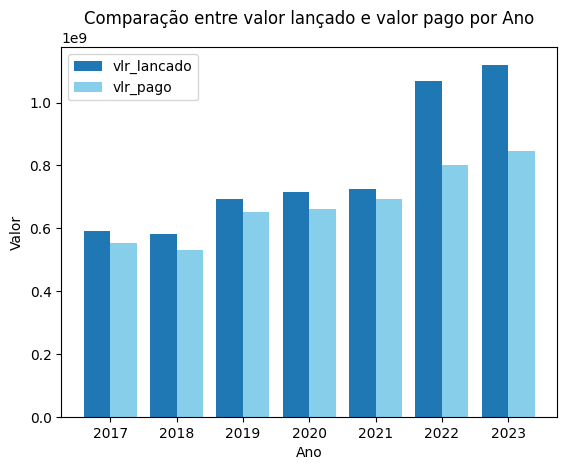

In [59]:
agrupado_por_ano = feature_store_credito.groupby('ano')[['vlr_lancado', 'vlr_pago']].sum().reset_index()

plt.bar(agrupado_por_ano['ano'] - 0.2, agrupado_por_ano['vlr_lancado'], width=0.4, label='vlr_lancado')
plt.bar(agrupado_por_ano['ano'] + 0.2, agrupado_por_ano['vlr_pago'], width=0.4, label='vlr_pago', color='skyblue')

plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Comparação entre valor lançado e valor pago por Ano')
plt.legend()

plt.show()

In [60]:
somas_por_ano = feature_store_credito.groupby('ano')[['vlr_lancado', 'vlr_pago']].sum().reset_index()

somas_por_ano['inadimplência'] = somas_por_ano['vlr_lancado'] - somas_por_ano['vlr_pago']

somas_por_ano['vlr_lancado'] = somas_por_ano['vlr_lancado'].apply(formatar_moeda)
somas_por_ano['vlr_pago'] = somas_por_ano['vlr_pago'].apply(formatar_moeda)
somas_por_ano['inadimplência'] = somas_por_ano['inadimplência'].apply(formatar_moeda)

somas_por_ano

,ano,vlr_lancado,vlr_pago,inadimplência
0,2017.0,"R$ 592.370.647,03","R$ 551.601.559,56","R$ 40.769.087,47"
1,2018.0,"R$ 582.055.625,65","R$ 531.684.162,80","R$ 50.371.462,85"
2,2019.0,"R$ 692.983.814,85","R$ 652.201.760,79","R$ 40.782.054,06"
3,2020.0,"R$ 716.358.326,12","R$ 660.094.159,13","R$ 56.264.166,99"
4,2021.0,"R$ 724.835.525,78","R$ 692.003.242,17","R$ 32.832.283,61"
5,2022.0,"R$ 1.068.987.201,90","R$ 802.505.476,27","R$ 266.481.725,63"
6,2023.0,"R$ 1.120.403.852,07","R$ 846.627.752,14","R$ 273.776.099,93"


### CONTEXTO DO IMÓVEL

In [61]:
contribuinte = feature_store_credito.groupby(['id_contribuinte','id_imovel', 'ano']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'vlr_aberto': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first',
    'percentual_pago': 'first'
}).reset_index()

Analisando comportamento dos imóveis que estão presentes em todos os anos

In [63]:
contribuintes_em_todos_os_anos = set(contribuinte.groupby('id_imovel')['ano'].nunique()[lambda x: x == len(contribuinte['ano'].unique())].index)
contribuinte_em_todos_os_anos = contribuinte[contribuinte['id_imovel'].isin(contribuintes_em_todos_os_anos)]
contribuinte_em_todos_os_anos

,id_contribuinte,id_imovel,ano,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
3,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2017.0,0.0,1453.81,1453.81,0.0,0.0,2668.51,2668.51,0.0,2.0,0.0,0.0,0.0,0.0,1.0
4,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2018.0,0.0,1486.60,1486.60,0.0,0.0,4155.11,4155.11,0.0,3.0,0.0,0.0,0.0,0.0,1.0
5,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2019.0,0.0,1547.20,1547.20,0.0,0.0,5702.31,5702.31,0.0,4.0,0.0,0.0,0.0,0.0,1.0
6,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2020.0,0.0,1579.00,1579.00,0.0,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0
7,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2021.0,0.0,1633.00,1633.00,0.0,0.0,8914.31,8914.31,0.0,6.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922302,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2019.0,0.0,595.70,595.70,0.0,0.0,4678.52,4678.52,0.0,5.0,0.0,0.0,0.0,0.0,1.0
1922303,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2020.0,0.0,621.13,621.13,0.0,0.0,5310.62,5310.62,0.0,6.0,0.0,0.0,0.0,0.0,1.0
1922304,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2021.0,0.0,633.40,633.40,0.0,0.0,5944.02,5944.02,0.0,7.0,0.0,0.0,0.0,0.0,1.0
1922305,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2022.0,0.0,702.28,702.28,0.0,0.0,6648.40,6648.40,0.0,8.0,0.0,0.0,0.0,0.0,1.0


In [64]:
analise_contribuinte = contribuinte_em_todos_os_anos.groupby('ano').agg({
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum'
}).reset_index()


analise_contribuinte['percentual_pago'] = (analise_contribuinte['vlr_pago'] / analise_contribuinte['vlr_lancado']) * 100

analise_contribuinte = analise_contribuinte.sort_values(by='ano')

# Aumento do valor lançado
analise_contribuinte['aumento_valor_lancado'] = analise_contribuinte['vlr_lancado'].diff()
analise_contribuinte['aumento_valor_lancado'].fillna(0, inplace=True)
analise_contribuinte['percentual_aumento_valor_lancado'] = (analise_contribuinte['vlr_lancado'].diff() / analise_contribuinte['vlr_lancado'].shift()) * 100
analise_contribuinte['percentual_aumento_valor_lancado'].fillna(0, inplace=True)
analise_contribuinte['percentual_aumento_valor_pago'] = (analise_contribuinte['vlr_pago'].diff() / analise_contribuinte['vlr_pago'].shift()) * 100
analise_contribuinte['percentual_aumento_valor_pago'].fillna(0, inplace=True)

analise_contribuinte.columns = ['ano', 'id_imovel', 'vlr_pago', 'vlr_lancado', 'percentual_pago', 'aumento_valor_lancado', 'percentual_aumento_valor_lancado', 'percentual_aumento_valor_pago']

analise_contribuinte['vlr_lancado'] = analise_contribuinte['vlr_lancado'].apply(formatar_moeda)
analise_contribuinte['aumento_valor_lancado'] = analise_contribuinte['aumento_valor_lancado'].apply(formatar_moeda)
analise_contribuinte['vlr_pago'] = analise_contribuinte['vlr_pago'].apply(formatar_moeda)
analise_contribuinte

,ano,id_imovel,vlr_pago,vlr_lancado,percentual_pago,aumento_valor_lancado,percentual_aumento_valor_lancado,percentual_aumento_valor_pago
0,2017.0,177363,"R$ 407.653.947,04","R$ 428.795.952,45",95.069448,"R$ 0,00",0.000000,0.000000
1,2018.0,177363,"R$ 435.719.744,95","R$ 453.854.654,46",96.004247,"R$ 25.058.702,01",5.843969,6.884711
2,2019.0,177363,"R$ 465.203.111,96","R$ 478.495.719,89",97.222001,"R$ 24.641.065,43",5.429286,6.766590
3,2020.0,177363,"R$ 473.382.381,38","R$ 495.409.605,84",95.553735,"R$ 16.913.885,95",3.534804,1.758215
4,2021.0,177363,"R$ 498.598.901,00","R$ 512.015.072,89",97.379731,"R$ 16.605.467,05",3.351866,5.326882
5,2022.0,177363,"R$ 547.034.974,63","R$ 566.161.436,81",96.621730,"R$ 54.146.363,92",10.575150,9.714437
6,2023.0,177363,"R$ 568.914.880,47","R$ 600.840.150,50",94.686562,"R$ 34.678.713,69",6.125234,3.999727


* Segundo prefeitura de Recife em 2022 obteve um aumento de 10,67% no valor do IPTU cobrado com o aumento do IPCA (Índice de preços ao consumidor amplo)
* Isso é refletido nos dados observando a evolução dos mesmos imóveis entre 2017 e 2023 no ano de 2022 de 10.64%

## Novos imóveis - A cada ano os imóveis que não aparecem nos anos anteriores

In [65]:
analise = pd.DataFrame(contribuinte)
contagem_total = []
contagem_novos = []

imoveis_unicos_globais = set()

for ano in range(2017, 2024):
    df_ano_atual = analise[analise['ano'] == ano]
    
    imoveis_unicos_ano_atual = set(df_ano_atual['id_imovel'])
    contagem_total.append(len(imoveis_unicos_ano_atual))

    imoveis_novos = imoveis_unicos_ano_atual - imoveis_unicos_globais
    contagem_novos.append(len(imoveis_novos))
    
    imoveis_unicos_globais.update(imoveis_unicos_ano_atual)

contagem_df = pd.DataFrame({'Ano': list(range(2017, 2024)),
                            'Total': contagem_total,
                            'Novos': contagem_novos})
contagem_df

,Ano,Total,Novos
0,2017,246112,246112
1,2018,232462,21328
2,2019,257577,12650
3,2020,253701,7199
4,2021,250149,5520
5,2022,338180,52577
6,2023,344126,3777


In [75]:
(21328+12650+7199+5520+52577) / 5

19854.8

### Verificação de imóveis novos em relação ao ano anterior

In [71]:
contra_prova = pd.DataFrame(contribuinte)

df_2021 = contra_prova[contra_prova['ano'] == 2018]
df_2022 = contra_prova[contra_prova['ano'] == 2019]
imoveis_unicos_2021 = set(df_2021['id_imovel'])
imoveis_unicos_2022 = set(df_2022['id_imovel'])

imoveis_novos_2022 = imoveis_unicos_2022 - imoveis_unicos_2021
quantidade_imoveis_novos_2022 = len(imoveis_novos_2022)

print(f"Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: {quantidade_imoveis_novos_2022}")

Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: 38423


### Descritivo dos registros que apareceram em 2022 e não apareceram nos anos anteriores

In [66]:
ano_interesse = 2022

id_imoveis_ano_interesse = set(feature_store_credito[feature_store_credito['ano'] == ano_interesse]['id_imovel'])
id_imoveis_anos_anteriores = set(feature_store_credito[feature_store_credito['ano'] < ano_interesse]['id_imovel'])

id_imoveis_novos_2022 = id_imoveis_ano_interesse - id_imoveis_anos_anteriores

registros_imoveis_novos_2022 = feature_store_credito[(feature_store_credito['ano'] == ano_interesse) & (feature_store_credito['id_imovel'].isin(id_imoveis_novos_2022))]
registros_imoveis_novos_2022

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
124,000554c5705b8f31be91dcec7d89e48e,222265876522c289875350beaddc7871,5f537f5f4c7b5d64,2022.0,38.0,227.00,1,CASA,SANCHO,1,...,369.82,3634.09,2.0,3.0,1.0,0.000,1.0,0.818182,0.0,1.0
125,000554c5705b8f31be91dcec7d89e48e,3d2d5ea17fa2abb6875350beaddc7871,0fd2704b768f5ec1,2022.0,38.0,50.00,1,CASA,TEJIPIO,1,...,369.82,3634.09,2.0,3.0,1.0,0.000,1.0,0.818182,0.0,1.0
158,000627afce004bd2d4613fe022d53698,1a49f9493c4502c0875350beaddc7871,5c7d6bee95365501,2022.0,54.0,41.29,1,APARTAMENTO,BOA VISTA,1,...,0.00,427.44,2.0,1.0,1.0,0.000,1.0,0.750000,0.0,1.0
245,000a0685733c58fcd8b209292c0ce31d,a13b51bb2cc26ca5875350beaddc7871,d199dbe03307c331,2022.0,42.0,55.00,1,APARTAMENTO,MUSTARDINHA,1,...,0.00,386.27,2.0,1.0,1.0,0.000,1.0,0.818182,0.0,1.0
263,000af8d8be6de7c31db4804237c116dd,d8dcda5a0bcbf2db875350beaddc7871,9592dd651ab79d8b,2022.0,41.0,82.25,1,APARTAMENTO,AREIAS,0,...,1513.43,1513.43,1.0,2.0,1.0,0.000,1.0,0.800000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923795,fff5f3d945bfe3d076beb59f44c20df3,f5bec795df55fd24875350beaddc7871,ea575e456771ef38,2022.0,36.0,70.00,1,CASA,BONGI,1,...,2973.15,4724.20,2.0,6.0,1.0,0.000,1.0,0.818182,0.0,1.0
1923837,fff8aff6848c2d188e79cf1867e8cc19,e9059839361d3967875350beaddc7871,40f5c4dc59762a58,2022.0,32.0,54.50,1,APARTAMENTO,VARZEA,1,...,14599.25,18209.18,2.0,7.0,1.0,0.125,1.0,0.800000,0.0,1.0
1923846,fff9325728d059d81603ecd7ff6be21f,b23dba1130b282db875350beaddc7871,b3503af7cfe8182f,2022.0,41.0,71.47,1,APARTAMENTO,AREIAS,1,...,0.00,2160.17,2.0,3.0,1.0,0.000,1.0,0.714286,0.0,1.0
1923889,fffafcbc80a2ab2a1603ecd7ff6be21f,5cca6bf618589050875350beaddc7871,c79c2476626fa4b6,2022.0,34.0,60.00,1,CASA,BREJO DA GUABIRABA,1,...,35845.37,37570.46,2.0,7.0,1.0,0.000,1.0,0.777778,0.0,1.0


In [74]:
# formatar_moeda(registros_imoveis_novos_2022['vlr_aberto'].sum())
registros_imoveis_novos_2022['tipo_propriedade'].value_counts()

CASA                         21806
APARTAMENTO                  16567
TERRENO                       5679
SALA                          3505
LOJA                          2904
GALPÃO                         714
EDIFICAÇÃO ESPECIAL            584
GARAGEM COMERCIAL              404
MOCAMBO                        189
HOTEL                           68
INDUSTRIA                       66
INSTITUIÇÃO FINANCEIRA          24
INSTITUIÇÃO EDUCACIONAL         17
HOSPITAL                        16
CENTRO COMERCIAL/SERVIÇOS       13
TEMPLO RELIGIOSO                10
GALPÃO FECHADO                   9
POSTO DE ABASTECIMENTO           1
LOJA MÚLTIPLA                    1
Name: tipo_propriedade, dtype: int64

In [80]:
registros_imoveis_novos_2022.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro
count,52577,52577,52577,52577,52577
unique,35503,52577,52577,19,94
top,878ed023fa473bede000edc2a2086273,222265876522c289875350beaddc7871,5f537f5f4c7b5d64,CASA,BOA VIAGEM
freq,909,1,1,21806,4188


In [81]:
individuo_devedor = registros_imoveis_novos_2022.query('id_contribuinte =="878ed023fa473bede000edc2a2086273"')
individuo_devedor

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
1007864,878ed023fa473bede000edc2a2086273,0007800e7f730279875350beaddc7871,e41e0edbe3db3d28,2022.0,39.0,151.84,1,CASA,ENGENHO DO MEIO,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1007869,878ed023fa473bede000edc2a2086273,006aa2b2501876b5875350beaddc7871,05b5f6c7fe9b6d62,2022.0,21.0,64.05,1,APARTAMENTO,SANCHO,0,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,1.0,0.0
1007874,878ed023fa473bede000edc2a2086273,00c4518a157926a8875350beaddc7871,dd59b6cabf35c493,2022.0,21.0,64.05,1,APARTAMENTO,SANCHO,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1007887,878ed023fa473bede000edc2a2086273,015def34d902f246875350beaddc7871,e96d62aa1f3e5867,2022.0,31.0,0.00,0,TERRENO,BREJO DA GUABIRABA,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1007902,878ed023fa473bede000edc2a2086273,01daaf0f87c3082d875350beaddc7871,0ce86f63a46a2d44,2022.0,52.0,149.44,1,CASA,JARDIM SAO PAULO,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013601,878ed023fa473bede000edc2a2086273,fe6ca9eb82e66c7d875350beaddc7871,e48a0eb3a0703e1f,2022.0,41.0,0.00,0,TERRENO,COHAB,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1013603,878ed023fa473bede000edc2a2086273,fe7cdd4987651229875350beaddc7871,acb1be9566e665ae,2022.0,36.0,180.00,1,CASA,COHAB,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1013623,878ed023fa473bede000edc2a2086273,ff7f88a7deb7cc72875350beaddc7871,264ba5bc21db1d93,2022.0,42.0,650.00,1,APARTAMENTO,COHAB,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1013625,878ed023fa473bede000edc2a2086273,ff884d10f09c4dfc875350beaddc7871,a4b037ae38bd4e15,2022.0,41.0,0.00,0,TERRENO,COHAB,1,...,1937462.1,6347704.5,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0


In [443]:
formatar_moeda(individuo_devedor['vlr_lancado'].sum())

'R$ 1.566.325,78'

In [444]:
formatar_moeda(individuo_devedor['vlr_pago'].sum())

'R$ 13.562,73'

---

# INICIANDO CONSTRUÇÃO DO MODELO

# Seleção de variáveis

In [71]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['tipo_propriedade_encoded'] = le.fit_transform(feature_store_credito['tipo_propriedade'])

print("tipo_propriedade originais:", feature_store_credito['tipo_propriedade'].unique())
print("tipo_propriedade codificados:", feature_store_credito['tipo_propriedade_encoded'].unique())

tipo_propriedade originais: ['CASA' 'APARTAMENTO' 'SALA' 'LOJA' 'TERRENO' 'GARAGEM COMERCIAL'
 'EDIFICAÇÃO ESPECIAL' 'GALPÃO' 'MOCAMBO' 'INDUSTRIA'
 'INSTITUIÇÃO EDUCACIONAL' 'INSTITUIÇÃO FINANCEIRA'
 'CENTRO COMERCIAL/SERVIÇOS' 'HOTEL' 'GALPÃO FECHADO' 'HOSPITAL'
 'TEMPLO RELIGIOSO' 'POSTO DE ABASTECIMENTO' 'LOJA MÚLTIPLA'
 'GARAGEM RESIDENCIAL']
tipo_propriedade codificados: [ 1  0 17 13 19  6  3  4 15 10 11 12  2  9  5  8 18 16 14  7]


In [72]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['bairro_encoded'] = le.fit_transform(feature_store_credito['bairro'])

print("Bairros originais:", feature_store_credito['bairro'].unique())
print("Bairros codificados:", feature_store_credito['bairro_encoded'].unique())

Bairros originais: ['AREIAS ' 'AFLITOS ' 'BOA VIAGEM ' 'BOA VISTA ' 'CORDEIRO '
 'ALTO DO MANDU ' 'SAN MARTIN ' 'CASA AMARELA ' 'PARNAMIRIM ' 'GRACAS '
 'PINA ' 'JARDIM SAO PAULO ' 'SANCHO ' 'TEJIPIO ' 'ENGENHO DO MEIO '
 'ESPINHEIRO ' 'SANTANA ' 'TORROES ' 'ENCRUZILHADA ' 'AGUA FRIA '
 'HIPODROMO ' 'MUSTARDINHA ' 'BEBERIBE ' 'PRADO ' 'CAXANGA '
 'IMBIRIBEIRA ' 'TORRE ' 'FUNDAO ' 'IPSEP ' 'TAMARINEIRA ' 'JORDAO '
 'CAMPO GRANDE ' 'VARZEA ' 'DOIS UNIDOS ' 'MONTEIRO ' 'CACOTE '
 'MACAXEIRA ' 'POCO ' 'IPUTINGA ' 'IBURA ' 'SOLEDADE ' 'SANTO AMARO '
 'CASA FORTE ' 'LINHA DO TIRO ' 'COQUEIRAL ' 'CAMPINA DO BARRETO '
 'ROSARINHO ' 'AFOGADOS ' 'SANTO ANTONIO ' 'MADALENA ' 'BARRO ' 'ARRUDA '
 'JIQUIA ' 'MANGUEIRA ' 'ILHA DO LEITE ' 'CURADO ' 'GUABIRABA '
 'CAJUEIRO ' 'PONTO DE PARADA ' 'BREJO DA GUABIRABA ' 'VASCO DA GAMA '
 'SAO JOSE ' 'PORTO DA MADEIRA ' 'DERBY ' 'APIPUCOS ' 'JAQUEIRA ' 'COHAB '
 'BONGI ' 'BRASILIA TEIMOSA ' 'ILHA DO RETIRO ' 'TOTO ' 'CABANGA '
 'CORREGO DO JENIPAPO ' 'BREJO 

In [73]:
feature_store_credito['perc_hist_pago'] = (feature_store_credito['hist_pagamento'] / feature_store_credito['hist_lancado']).fillna(0)

In [74]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded'],
      dtype='object')

In [75]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2022')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [76]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'tipo_contribuinte', 'percentual_pago',
             'tipo_propriedade_encoded']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa',
       'tipo_contribuinte', 'percentual_pago', 'tipo_propriedade_encoded'],
      dtype='object')

# São 479 registros de 77 contribuintes em que não há histórico para os mesmos

In [77]:
variaveis_selecionadas.isnull().sum()

idade_imovel                      0
num_imoveis                       0
natureza_imovel                   0
reco_credito                      0
perc_hist_pago                    0
percentual_reco_debito            0
percentual_pago_cota              0
reco_divida_ativa                 0
percentual_reco_divida_ativa      0
tipo_contribuinte               223
percentual_pago                   0
tipo_propriedade_encoded          0
dtype: int64

In [78]:
variaveis_selecionadas.query('tipo_contribuinte.isnull()')

,idade_imovel,num_imoveis,natureza_imovel,reco_credito,perc_hist_pago,percentual_reco_debito,percentual_pago_cota,reco_divida_ativa,percentual_reco_divida_ativa,tipo_contribuinte,percentual_pago,tipo_propriedade_encoded
8704,55.0,1.0,1,3.0,1.000000,1.000000,0.000000,1.0,1.000000,NaN,1.0,1
15983,26.0,5.0,1,10.0,0.985429,0.181818,0.090909,0.0,0.333333,NaN,1.0,13
19499,25.0,1.0,1,4.0,0.645296,0.800000,0.000000,1.0,0.600000,NaN,0.0,1
21661,28.0,1.0,1,8.0,1.000000,0.000000,0.000000,0.0,0.000000,NaN,1.0,17
22192,37.0,1.0,1,2.0,0.172127,1.000000,0.000000,1.0,0.818182,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1850073,23.0,1.0,1,7.0,1.000000,0.000000,0.000000,0.0,0.000000,NaN,1.0,0
1858989,15.0,1.0,1,7.0,1.000000,0.000000,0.125000,0.0,0.000000,NaN,1.0,0
1901849,41.0,1.0,0,1.0,0.000000,1.000000,0.000000,1.0,0.818182,NaN,0.0,19
1903581,38.0,1.0,1,2.0,0.139083,1.000000,0.000000,1.0,0.777778,NaN,0.0,0


In [79]:
variaveis_selecionadas = variaveis_selecionadas.dropna(subset=['tipo_contribuinte'])

In [80]:
variaveis_selecionadas.isnull().sum()

idade_imovel                    0
num_imoveis                     0
natureza_imovel                 0
reco_credito                    0
perc_hist_pago                  0
percentual_reco_debito          0
percentual_pago_cota            0
reco_divida_ativa               0
percentual_reco_divida_ativa    0
tipo_contribuinte               0
percentual_pago                 0
tipo_propriedade_encoded        0
dtype: int64

---

# Incrementando o feature store

In [355]:
hist_dams_counts = feature_store_credito.groupby('id_contribuinte')['dam'].nunique()
feature_store_credito['hist_dams'] = feature_store_credito['id_contribuinte'].map(hist_dams_counts)

feature_store_credito[['ano','id_contribuinte', 'dam', 'reco_divida_ativa', 'hist_dams']].query('id_contribuinte == "0000398c485f8b42344d77602867ec09"')

,ano,id_contribuinte,dam,reco_divida_ativa,hist_dams
0,2023.0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,0.0,3
1,2017.0,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,0.0,3
2,2022.0,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1.0,3


In [358]:
teste = feature_store_credito.copy()
teste['target_prob'] = teste.groupby('id_contribuinte')['reco_divida_ativa'].transform('mean')
teste[['ano','id_contribuinte', 'dam', 'reco_divida_ativa', 'hist_dams', 'entrou_em_divida', 'target_prob']].query('id_contribuinte == "0000398c485f8b42344d77602867ec09"')


,ano,id_contribuinte,dam,reco_divida_ativa,hist_dams,entrou_em_divida,target_prob
0,2023.0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,0.0,3,0,0.333333
1,2017.0,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,0.0,3,0,0.333333
2,2022.0,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1.0,3,1,0.333333


# VARIÁVEL TARGET

In [359]:
feature_store_credito['entrou_em_divida'] = feature_store_credito['reco_divida_ativa'].apply(lambda x: 1 if x != 0 else 0)

In [360]:
contagem_por_ano = feature_store_credito.groupby(['ano', 'entrou_em_divida']).size().unstack()
contagem_por_ano.columns = ['não_entrou_em_divida', 'entrou_em_divida']
contagem_por_ano


,não_entrou_em_divida,entrou_em_divida
ano,,
2017.0,208447,38692
2018.0,186151,46471
2019.0,202117,55675
2020.0,207525,46239
2021.0,204500,45723
2022.0,198109,140169
2023.0,328611,15603


In [362]:
feature_store_credito_17 = feature_store_credito.query('ano == 2017')
feature_store_credito_18 = feature_store_credito.query('ano == 2018')
feature_store_credito_19 = feature_store_credito.query('ano == 2019')
feature_store_credito_20 = feature_store_credito.query('ano == 2020')
feature_store_credito_21 = feature_store_credito.query('ano == 2021')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_20_21 = feature_store_credito.query('(ano > 2019) & (ano < 2022)')
feature_store_credito_22_23 = feature_store_credito.query('(ano > 2021) & (ano < 2024)')
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2022')
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')

In [414]:
total_registros = len(feature_store_credito_20)
contagem_por_label = feature_store_credito_20['entrou_em_divida'].value_counts()

porcentagem_por_label = (contagem_por_label / total_registros) * 100

resultados = pd.DataFrame({
    'Label': porcentagem_por_label.index,
    'Quantidade': contagem_por_label.values,
    'Porcentagem do Total': porcentagem_por_label.values
})
resultados

,Label,Quantidade,Porcentagem do Total
0,0,207383,81.779501
1,1,46205,18.220499


In [415]:
feature_store_credito_20.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded',
       'entrou_em_divida', 'hist_dams'],
      dtype='object')

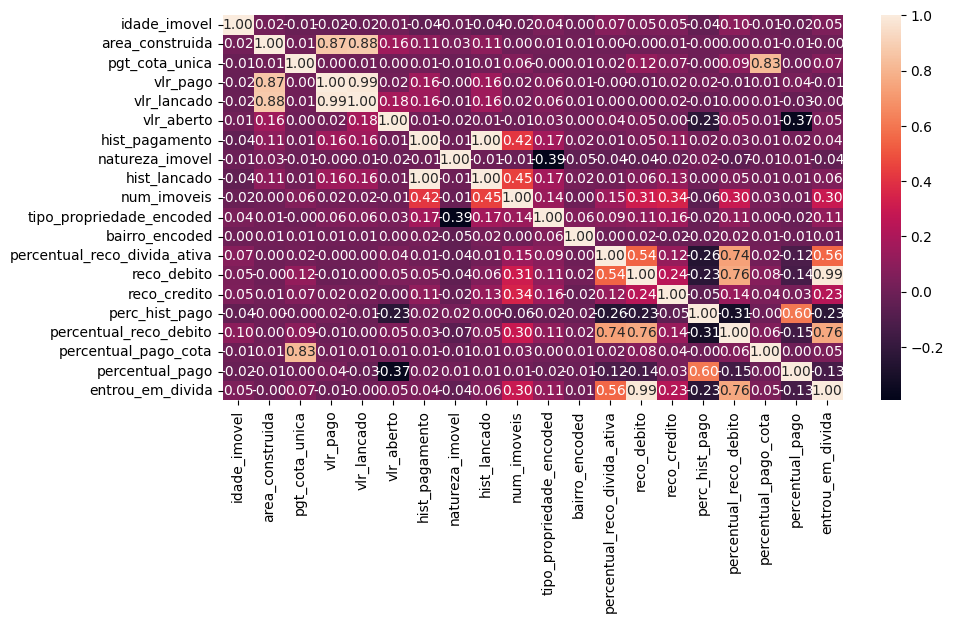

In [416]:
matriz_correlacao = feature_store_credito_20[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 'natureza_imovel',
                                    'hist_lancado', 'num_imoveis', 'tipo_propriedade_encoded', 'bairro_encoded',
                                    'percentual_reco_divida_ativa','reco_debito','reco_credito',
                                    'perc_hist_pago','percentual_reco_debito','percentual_pago_cota', 
                                    'percentual_pago','entrou_em_divida']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [417]:
feature_store_credito_20_21 = feature_store_credito_20_21.dropna(subset=['tipo_contribuinte'])
feature_store_credito_20_21.isnull().sum()

id_contribuinte                 0
dam                             0
id_imovel                       0
ano                             0
idade_imovel                    0
area_construida                 0
natureza_imovel                 0
tipo_propriedade                0
bairro                          0
aberto                          0
num_imoveis                     0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
pgt_cota_unica                  0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_debito                     0
reco_credito                    0
reco_divida_ativa               0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
percentual_pago                 0
tipo_contribuinte               0
tipo_propriedade_encoded        0
perc_hist_pago                  0
bairro_encoded                  0
entrou_em_divi

# balanceamento dos dados de treino e teste

### Eu tenho 1.205.989 registros onde não há recorrência em dívida ativa 
### Eu tenho 372.726 registros onde há recorrência em dívida ativa

A ideia é tentar balancear as classes de aprendizado 50% a 50%

In [204]:
0.30906 * 1205989

372722.96034

In [205]:
# Subamostra aleatória percentual_reco_divida_ativa = 0
amostra_sem_divida = feature_store_credito_ate_22[feature_store_credito_ate_22['entrou_em_divida'] == 0].sample(frac=0.30906, random_state=42)

# Subamostra aleatória percentual_reco_divida_ativa diferente de  0
amostra_em_divida = feature_store_credito_ate_22[feature_store_credito_ate_22['entrou_em_divida'] != 0].sample(frac=1.0, random_state=42)

# Unindo 
dados_balanceados = pd.concat([amostra_sem_divida, amostra_em_divida])
dados_balanceados = dados_balanceados.sample(frac=1, random_state=42)

dados_balanceados

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,entrou_em_divida
1782160,ed39fea7c8b8c86304e9bf7bbd37f8aa,7c4efbc5c36e72914c1f696350fff79e,5f2463b12ab768ba,2019.0,44.0,249.53,1,APARTAMENTO,BOA VIAGEM,0,...,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0,1.000000,12,0
1341850,b1f141b88b49d79dbe91dcec7d89e48e,ae2b41603c3bb7d54c1f696350fff79e,0861f3d25f266ebf,2019.0,19.0,171.16,1,APARTAMENTO,BOA VIAGEM,0,...,1.0,0.000000,1.000000,0.833333,1.000000,1.0,0,0.465193,12,1
550468,48f3d1a8212ccbed75234379af146d63,c1c3ceb0ab21b99d875350beaddc7871,9d5dac8dc157fc72,2022.0,25.0,140.44,1,CASA,BARRO,1,...,1.0,0.000000,1.000000,0.818182,0.000000,1.0,1,0.000000,10,1
761310,6639fd073122e203d98069c8dccd45d6,0df159063c99ddda875350beaddc7871,1b56d1a51ba600ed,2022.0,7.0,144.49,1,APARTAMENTO,ROSARINHO,0,...,0.0,0.142857,0.000000,0.000000,1.000000,1.0,0,1.000000,77,0
1048637,8c3ac440100e58cad8b209292c0ce31d,661f676c7a0c737b4c1f696350fff79e,53438945a8bfa07d,2019.0,36.0,45.00,1,APARTAMENTO,TEJIPIO,0,...,1.0,0.000000,0.444444,0.444444,1.000000,1.0,0,0.406595,87,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813002,6d090f844a783a5efafaebd1073fc2f4,ee8fa6afcc2134a90ba9f03948490762,c61ff09ded830c59,2020.0,13.0,48.91,1,APARTAMENTO,BOA VIAGEM,0,...,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0,1.000000,12,0
669523,594e7c434b32e2989daa7b7dbb545c1c,18ec2e8f44c642164c1f696350fff79e,2857af7f9f590d48,2019.0,60.0,96.50,1,APARTAMENTO,GRACAS,0,...,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0,1.000000,43,0
670609,5979769842c71a8e7b9c14f65387b89e,b7bab4ff25530e81875350beaddc7871,aa7d19108d7960ff,2022.0,84.0,160.58,1,CASA,BARRO,1,...,0.0,0.000000,0.111111,0.000000,0.727944,1.0,1,0.951488,10,0
1341796,b1edbe2fe72c3f9800b3f2da8c6092e4,7b5e338095a2f281875350beaddc7871,5e2c00a6a43503b1,2022.0,36.0,31.50,1,CASA,TORROES,1,...,1.0,0.000000,1.000000,0.800000,0.000000,1.0,1,0.000000,90,1


# REGRESSÃO LOGÍSTICA

In [418]:
feature_store_credito_20.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded',
       'entrou_em_divida', 'hist_dams'],
      dtype='object')

In [419]:
feature_store_credito_20.shape[0]

253588

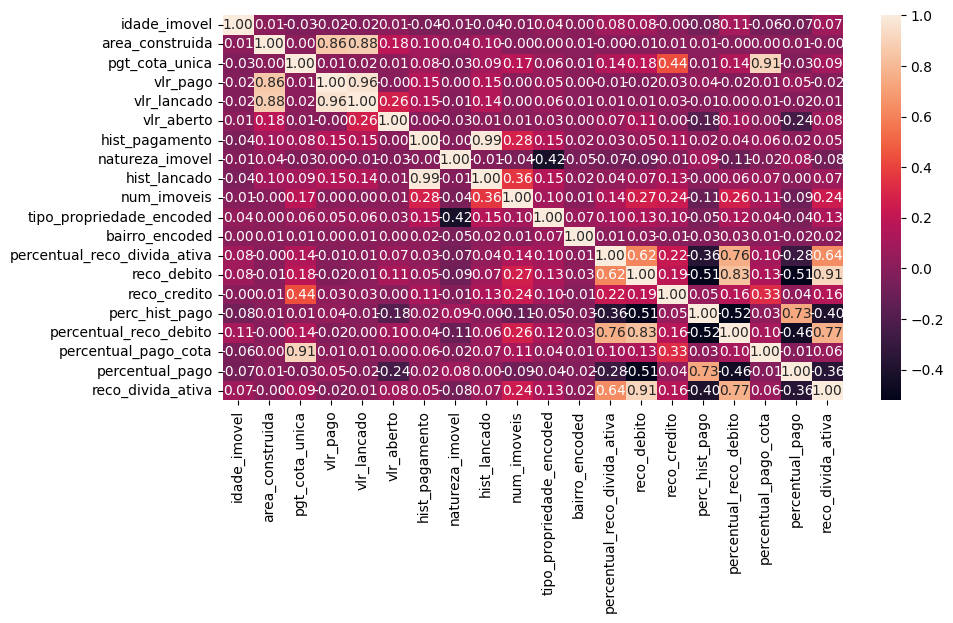

In [421]:
variaveis = ['idade_imovel','vlr_aberto', 'natureza_imovel', 'num_imoveis',
             'tipo_propriedade_encoded', 'reco_credito', 'perc_hist_pago',
             'percentual_reco_debito','percentual_pago_cota','percentual_pago', 'entrou_em_divida']
variaveis_selecionadas = feature_store_credito_20[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'vlr_aberto', 'natureza_imovel', 'num_imoveis',
       'tipo_propriedade_encoded', 'reco_credito', 'perc_hist_pago',
       'percentual_reco_debito', 'percentual_pago_cota', 'percentual_pago',
       'entrou_em_divida'],
      dtype='object')

In [422]:
contagem_labels = variaveis_selecionadas['entrou_em_divida'].value_counts()
contagem_labels

0    207383
1     46205
Name: entrou_em_divida, dtype: int64

In [423]:
y = variaveis_selecionadas['entrou_em_divida']
x = variaveis_selecionadas.drop(columns=['entrou_em_divida'])

In [424]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)

In [425]:
normalizador = RobustScaler() #StandardScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

## REGRESSÃO LOGÍSTICA XGBOOST

In [426]:
xbg_logistico = XGBClassifier(objective="binary:logistic", random_state=42)
xbg_logistico.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [427]:
Predicao_probabilidade = xbg_logistico.predict_proba(X_test)[:, 1]

In [428]:
Predicao_0_ou_1 = xbg_logistico.predict(X_test)

In [429]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Verdadeiro Negativo', 'Verdadeiro Positivo'], columns=['Falso Negativo', 'Falso Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Falso Negativo,Falso Positivo
Verdadeiro Negativo,60858,1436
Verdadeiro Positivo,3186,10597


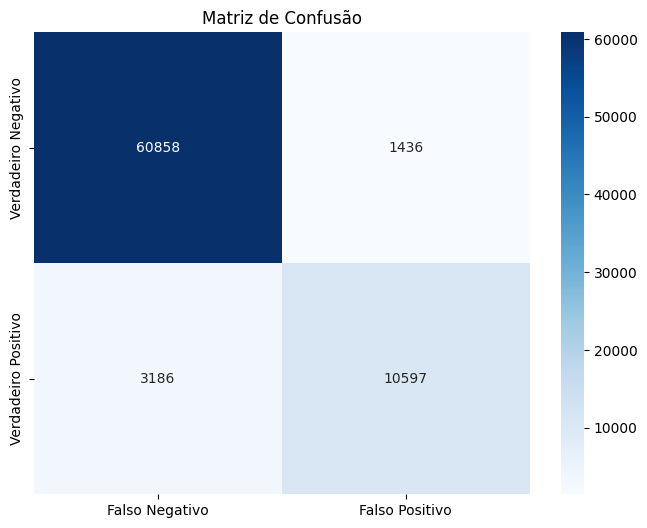

In [430]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [431]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.9392457641599958
ROC AUC: 0.9823529766720849
Precisão: 0.8806615141693676
Revocação (Sensibilidade): 0.7688456794602045
F1 Score: 0.8209637434149365


---

## REGRESSÃO LOGÍSTICA

In [381]:
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train, y_train)

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [382]:
Predicao_probabilidade = modelo_logistico.predict_proba(X_test)[:, 1]

In [383]:
Predicao_0_ou_1 = modelo_logistico.predict(X_test)

In [384]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Verdadeiro Negativo', 'Verdadeiro Positivo'], columns=['Falso Negativo', 'Falso Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Falso Negativo,Falso Positivo
Verdadeiro Negativo,119474,4111
Verdadeiro Positivo,10667,16838


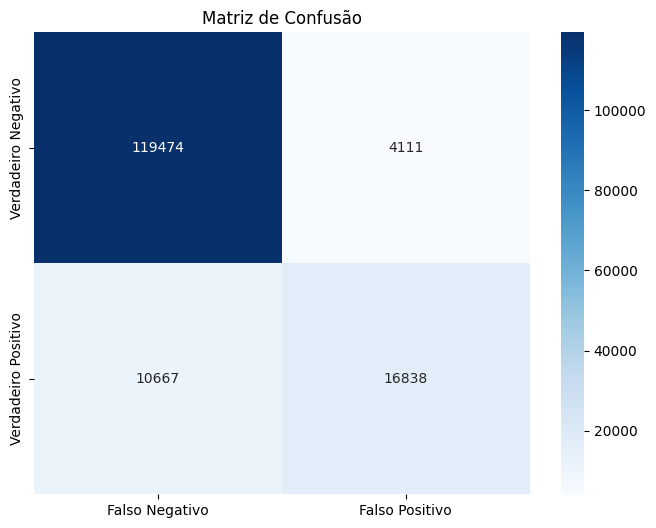

In [385]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [386]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.9021907472367463
ROC AUC: 0.9217563591350175
Precisão: 0.8037615160628192
Revocação (Sensibilidade): 0.6121796037084166
F1 Score: 0.6950096999215751


---

# PREDIÇÃO EM DADOS DE 2022 e 2023

In [451]:
feature_store_credito_22.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded',
       'entrou_em_divida', 'hist_dams'],
      dtype='object')

In [452]:
df_feature_store_predict = feature_store_credito_22.copy()

In [453]:
df_feature_store_predict.isnull().sum()

id_contribuinte                   0
dam                               0
id_imovel                         0
ano                               0
idade_imovel                      0
area_construida                   0
natureza_imovel                   0
tipo_propriedade                  0
bairro                            0
aberto                            0
num_imoveis                       0
vlr_aberto                        0
vlr_pago                          0
vlr_lancado                       0
pgt_cota_unica                    0
hist_cota_unica                   0
hist_pagamento                    0
hist_lancado                      0
reco_debito                       0
reco_credito                      0
reco_divida_ativa                 0
percentual_pago_cota              0
percentual_reco_debito            0
percentual_reco_divida_ativa      0
percentual_pago                   0
tipo_contribuinte               223
tipo_propriedade_encoded          0
perc_hist_pago              

In [454]:
df_feature_store_predict.shape[0]

338278

In [455]:
df_feature_store_predict.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,entrou_em_divida,hist_dams
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,56.0,110.15,1,CASA,AREIAS,1,...,0.000,1.0,0.6,0.0,1.0,1,0.343349,8,1,3
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.000,0.0,0.0,1.0,1.0,0,1.000000,0,0,7
11,000046c85d18a6f7968646cfc1e328f2,43f61322c00d0a2a875350beaddc7871,4c440987414316f6,2022.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.125,0.0,0.0,1.0,1.0,0,1.000000,12,0,7
20,0000b23be5378f1b8e79cf1867e8cc19,2489dc70da197fd8875350beaddc7871,f4a09ae3e8291db3,2022.0,54.0,28.00,1,SALA,BOA VISTA,0,...,0.125,0.0,0.0,1.0,1.0,17,1.000000,13,0,28
36,0000b23be5378f1b8e79cf1867e8cc19,d4377c5f6f787b9c875350beaddc7871,e8f779a348c050b1,2022.0,54.0,32.00,1,SALA,BOA VISTA,0,...,0.125,0.0,0.0,1.0,1.0,17,1.000000,13,0,28


# Balanceamento dos dados

In [456]:
total_registros = len(df_feature_store_predict)
contagem_por_label = df_feature_store_predict['entrou_em_divida'].value_counts()

porcentagem_por_label = (contagem_por_label / total_registros) * 100

resultados = pd.DataFrame({
    'Label': porcentagem_por_label.index,
    'Quantidade': contagem_por_label.values,
    'Porcentagem do Total': porcentagem_por_label.values
})
resultados

,Label,Quantidade,Porcentagem do Total
0,0,198109,58.563962
1,1,140169,41.436038


In [457]:
variaveis = ['idade_imovel','vlr_aberto', 'natureza_imovel', 'num_imoveis',
             'tipo_propriedade_encoded', 'reco_credito', 'perc_hist_pago',
             'percentual_reco_debito','percentual_pago_cota','percentual_pago', 'entrou_em_divida']
variaveis_selecionadas = df_feature_store_predict[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'vlr_aberto', 'natureza_imovel', 'num_imoveis',
       'tipo_propriedade_encoded', 'reco_credito', 'perc_hist_pago',
       'percentual_reco_debito', 'percentual_pago_cota', 'percentual_pago',
       'entrou_em_divida'],
      dtype='object')

In [458]:
variaveis_selecionadas.isnull().sum()

idade_imovel                0
vlr_aberto                  0
natureza_imovel             0
num_imoveis                 0
tipo_propriedade_encoded    0
reco_credito                0
perc_hist_pago              0
percentual_reco_debito      0
percentual_pago_cota        0
percentual_pago             0
entrou_em_divida            0
dtype: int64

In [459]:
y = variaveis_selecionadas['entrou_em_divida']
x = variaveis_selecionadas.drop(columns=['entrou_em_divida'])

In [460]:
observado = df_feature_store_predict['entrou_em_divida']

# XGBOOST

In [461]:
predicao_0_1 = xbg_logistico.predict(x)
predicao = xbg_logistico.predict_proba(x)[:, 1]

In [462]:
conf_matrix = confusion_matrix(observado, predicao_0_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Verdadeiro Negativo', 'Verdadeiro Positivo'], columns=['Falso Negativo', 'Falso Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Falso Negativo,Falso Positivo
Verdadeiro Negativo,180620,17489
Verdadeiro Positivo,25935,114234


In [ ]:
conf_matrix = confusion_matrix(observado, predicao_0_1)
total_observacoes = len(observado)
conf_matrix_percentual = conf_matrix / total_observacoes * 100

rotulos_verdadeiros = ['Real Negativo', 'Real Positivo']
rotulos_previstos = ['Predito Negativo', 'Predito Positivo']

df_conf_matrix_percentual = pd.DataFrame(conf_matrix_percentual, index=rotulos_verdadeiros, columns=rotulos_previstos)
print("Matriz de Confusão em Percentual:")
df_conf_matrix_percentual

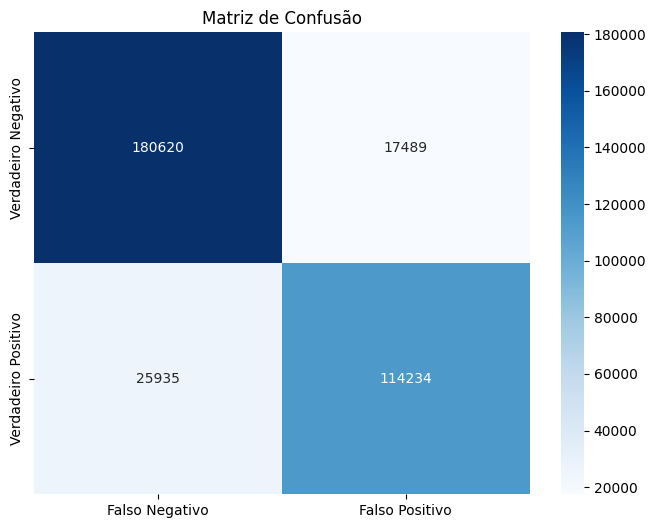

In [463]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Métricas do modelo em um conjunto de dados totalmente novo

In [447]:
acuracia = accuracy_score(observado, predicao_0_1)
roc_auc = roc_auc_score(observado, predicao)
precisao = precision_score(observado, predicao_0_1)
revocacao = recall_score(observado, predicao_0_1)
f1 = f1_score(observado, predicao_0_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.9191720984881486
ROC AUC: 0.9682478157109248
Precisão: 0.79680588536574
Revocação (Sensibilidade): 0.7485510574546727
F1 Score: 0.7719250764008706


In [448]:
range_predicoes = pd.DataFrame(predicao).rename(columns={0:'prob'})
range_predicoes

,prob
0,0.000006
1,0.000007
2,0.000009
3,0.000008
4,0.000009
...,...
250218,0.000008
250219,0.000006
250220,0.000008
250221,0.000007


In [449]:
def calcular_f1(y_true, y_prob, ponto_de_corte):
    y_pred = (y_prob >= ponto_de_corte).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return ponto_de_corte, f1, conf_matrix

In [450]:
hist_f1 = []
Falso_positivo = []
Verdadeiro_negativo = []
Falso_negativo = []
Verdadeiro_positivo = []

for ponto_de_corte in np.linspace(0.0, 0.99, num=50):
    ponto, f1, matriz_confusao = calcular_f1(observado.values, range_predicoes['prob'].values, ponto_de_corte)
    hist_f1.append(f1)
    Falso_positivo.append(matriz_confusao[0, 1])
    Falso_negativo.append(matriz_confusao[1, 0])
    Verdadeiro_negativo.append(matriz_confusao[0, 0])
    Verdadeiro_positivo.append(matriz_confusao[1, 1])

df_resultado = pd.DataFrame({
    'Limiar_corte': np.linspace(0.0, 0.99, num=50),
    'F1_Score': hist_f1,
    'Falso_positivo': Falso_positivo,
    'Verdadeiro_negativo': Verdadeiro_negativo,
    'Falso_negativo': Falso_negativo,
    'Verdadeiro_positivo': Verdadeiro_positivo
})
df_resultado = df_resultado.sort_values(by='F1_Score', ascending=False)
df_resultado

,Limiar_corte,F1_Score,Falso_positivo,Verdadeiro_negativo,Falso_negativo,Verdadeiro_positivo
20,0.404082,0.774818,11931,192569,9262,36461
22,0.444490,0.774255,10497,194003,10211,35512
19,0.383878,0.773765,12880,191620,8744,36979
21,0.424286,0.773381,11251,193249,9801,35922
23,0.464694,0.772586,9734,194766,10816,34907
24,0.484898,0.772530,9140,195360,11194,34529
25,0.505102,0.771776,8613,195887,11580,34143
18,0.363673,0.771273,14073,190427,8189,37534
26,0.525306,0.769886,8132,196368,12017,33706
27,0.545510,0.768984,7612,196888,12406,33317


# REGRESSÃO LOGISTICA

In [330]:
predicao_0_1_logit = modelo_logistico.predict(x)
predicao_logit = modelo_logistico.predict_proba(x)[:, 1]

# Regressão Logística

In [241]:
acuracia = accuracy_score(observado, predicao_0_1_logit)
roc_auc = roc_auc_score(observado, predicao_logit)
precisao = precision_score(observado, predicao_0_1_logit)
revocacao = recall_score(observado, predicao_0_1_logit)
f1 = f1_score(observado, predicao_0_1_logit)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.54755762403621
ROC AUC: 0.7837634967041058
Precisão: 0.08749661481943741
Revocação (Sensibilidade): 0.9525091328590656
F1 Score: 0.16027089253266186


# Achando limiar para corte

In [121]:
range_predicoes = pd.DataFrame(predicao).rename(columns={0:'prob'})
range_predicoes

,prob
0,0.018225
1,0.999994
2,0.999995
3,0.999999
4,0.999997
...,...
344209,0.999995
344210,0.999994
344211,0.999984
344212,0.999993


In [122]:
def calcular_f1(y_true, y_prob, ponto_de_corte):
    y_pred = (y_prob >= ponto_de_corte).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return ponto_de_corte, f1, conf_matrix

In [123]:
hist_f1 = []
Falso_positivo = []
Verdadeiro_negativo = []
Falso_negativo = []
Verdadeiro_positivo = []

for ponto_de_corte in np.linspace(0.0, 0.99, num=50):
    ponto, f1, matriz_confusao = calcular_f1(observado.values, range_predicoes['prob'].values, ponto_de_corte)
    hist_f1.append(f1)
    Falso_positivo.append(matriz_confusao[0, 1])
    Falso_negativo.append(matriz_confusao[1, 0])
    Verdadeiro_negativo.append(matriz_confusao[0, 0])
    Verdadeiro_positivo.append(matriz_confusao[1, 1])

df_resultado = pd.DataFrame({
    'Limiar_corte': np.linspace(0.0, 0.99, num=50),
    'F1_Score': hist_f1,
    'Falso_positivo': Falso_positivo,
    'Verdadeiro_negativo': Verdadeiro_negativo,
    'Falso_negativo': Falso_negativo,
    'Verdadeiro_positivo': Verdadeiro_positivo
})
df_resultado = df_resultado.query('F1_Score > 0.90')
df_resultado = df_resultado.sort_values(by='F1_Score', ascending=False)
df_resultado

,Limiar_corte,F1_Score,Falso_positivo,Verdadeiro_negativo,Falso_negativo,Verdadeiro_positivo
31,0.626327,0.926009,21106,81374,15110,226624
32,0.646531,0.925860,19976,82504,16152,225582
30,0.606122,0.925854,22385,80095,14078,227656
29,0.585918,0.925795,23382,79098,13246,228488
33,0.666735,0.925742,18888,83592,17143,224591
28,0.565714,0.925340,24535,77945,12462,229272
34,0.686939,0.925258,17740,84740,18350,223384
27,0.545510,0.924659,25829,76651,11663,230071
35,0.707143,0.924464,16392,86088,19865,221869
36,0.727347,0.923409,15314,87166,21260,220474


In [124]:
limiar = 0.626327
predicoes_binarias = (predicao >= limiar).astype(int)

In [125]:
df_resultado_predict = df_feature_store_predict.copy()

In [126]:
df_resultado_predict['predicao'] = predicao
df_resultado_predict['predicao_binaria'] = predicoes_binarias

# Definindo rating com base na probabilidade

In [297]:
hist = df_resultado_predict.query('aberto == 1')
hist = hist.query('predicao >= 0.05')
hist

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,pagamento,predicao,predicao_binaria
52,00014b72ca2a255bd4613fe022d53698,b1c496061b8ce3d290ecf5aaf6be6eb7,a60c24f0ce2caa81,2023.0,38.0,89.80,1,APARTAMENTO,CORDEIRO,1,...,0.111111,0.000000,0.774974,1.0,0,0.988763,31,0,0.300490,0
59,0001de7df29f8e85cd124eb8021f7dca,01978e90d064ce5090ecf5aaf6be6eb7,46db76d53b87a4d8,2023.0,42.0,47.00,1,CASA,ALTO DO MANDU,1,...,0.222222,0.500000,0.000000,1.0,1,0.830163,3,0,0.765670,1
61,0001de7df29f8e85cd124eb8021f7dca,0619ff80758de57790ecf5aaf6be6eb7,74c6887d5d9693b3,2023.0,42.0,45.00,1,CASA,ALTO DO MANDU,1,...,0.222222,0.500000,0.000000,1.0,1,0.830163,3,0,0.765670,1
101,000473f4656786d9d4613fe022d53698,a7c4990658a102d690ecf5aaf6be6eb7,2e037c9c5af02537,2023.0,21.0,138.48,1,APARTAMENTO,PARNAMIRIM,1,...,0.555556,0.600000,0.000000,1.0,0,0.165668,67,0,0.312307,0
162,0006da85fadfdfc1cd124eb8021f7dca,8bd82fd8f8527bd290ecf5aaf6be6eb7,6ce687e38073e56d,2023.0,41.0,101.69,1,APARTAMENTO,PARNAMIRIM,1,...,0.500000,0.750000,0.345050,1.0,0,0.506426,67,0,0.638890,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923824,fff8aff6848c2d188e79cf1867e8cc19,0df6a00dc23e448d90ecf5aaf6be6eb7,40f5c4dc59762a58,2023.0,32.0,54.50,1,APARTAMENTO,VARZEA,1,...,1.000000,0.800000,0.000000,1.0,0,0.737995,92,0,0.611147,0
1923825,fff8aff6848c2d188e79cf1867e8cc19,199d92ac4fb1e80690ecf5aaf6be6eb7,016f430a6302021e,2023.0,42.0,123.00,1,CASA,ENGENHO DO MEIO,1,...,1.000000,0.800000,0.000000,1.0,1,0.737995,39,0,0.691533,1
1923891,fffafcbc80a2ab2a1603ecd7ff6be21f,86276918391d68af90ecf5aaf6be6eb7,c79c2476626fa4b6,2023.0,34.0,60.00,1,CASA,BREJO DA GUABIRABA,1,...,1.000000,0.777778,0.000000,1.0,1,0.948412,17,0,0.491165,0
1923905,fffb82ff0c4ef8050246e2b93c1bf25c,49f07d673525777290ecf5aaf6be6eb7,263e230ea43a5599,2023.0,14.0,82.54,1,APARTAMENTO,TORRE,1,...,0.285714,0.500000,0.000000,1.0,0,0.779606,88,0,0.330093,0


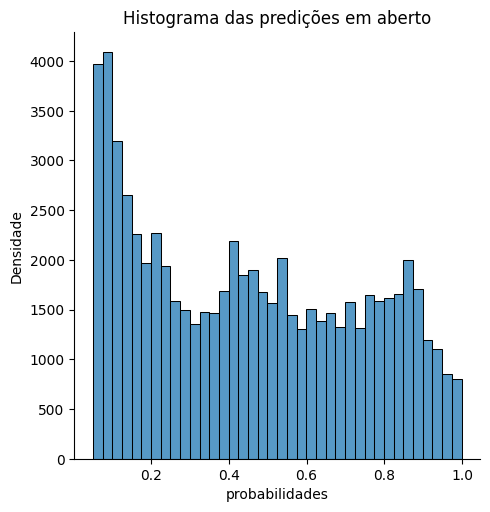

In [298]:
sns.displot(x='predicao', data=hist)

plt.title("Histograma das predições em aberto")
plt.xlabel("probabilidades")
plt.ylabel("Densidade")

plt.show()

# Definindo rating sobre a probabilidade

Definindo corte para ALTA E ALTISSIMA acima do limiar adotado

In [127]:
acima_do_limiar = df_resultado_predict.copy()
acima_do_limiar = acima_do_limiar.query('predicao >= 0.626327')

In [128]:
from sklearn.cluster import KMeans

limiar = 0.626327

acima_do_limiar['cluster'] = 0

# Ajusta o K-Means com 2 clusters para dados acima do limiar
dados_acima_limiar = acima_do_limiar[acima_do_limiar['predicao'] > limiar]['predicao'].values.reshape(-1, 1)
kmeans_acima_limiar = KMeans(n_clusters=2, random_state=42)
acima_do_limiar.loc[acima_do_limiar['predicao'] >= limiar, 'cluster'] = kmeans_acima_limiar.fit_predict(dados_acima_limiar)

Centroides acima do limiar

In [129]:
centroides_acima_limiar = acima_do_limiar.groupby('cluster')['predicao'].mean()
print("Centroides dos Clusters:")
pd.DataFrame(centroides_acima_limiar)

Centroides dos Clusters:


,predicao
cluster,
0,0.988741
1,0.774665


In [ ]:
# import pandas as pd
# from umap import UMAP

# predicao_selected = acima_do_limiar[['cluster', 'predicao']]

# umap_model = UMAP(n_components=2, random_state=22, min_dist=0.6)
# predicao_embedded = umap_model.fit_transform(predicao_selected)

# df_resultado_umap = pd.DataFrame(predicao_embedded, columns=['UMAP1', 'UMAP2'])
# df_resultado_umap = pd.concat([acima_do_limiar, df_resultado_umap], axis=1)
# df_resultado_umap

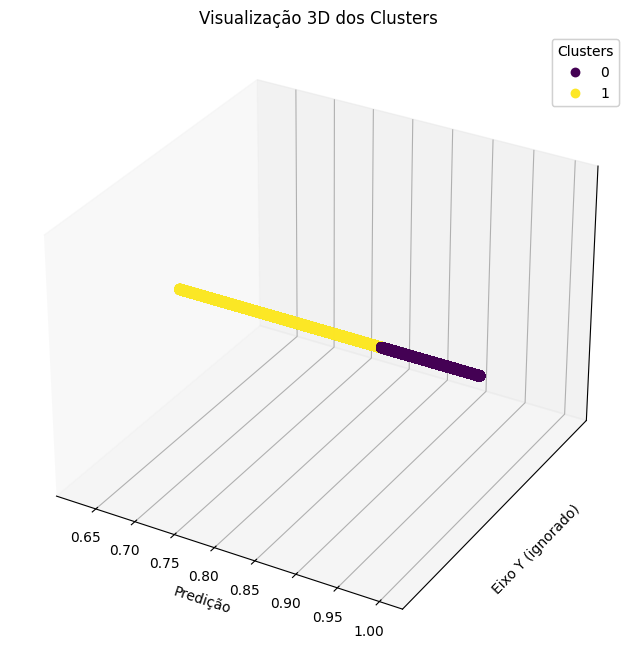

In [302]:
from mpl_toolkits.mplot3d import Axes3D

# Supondo que você tenha um DataFrame chamado 'acima_do_limiar'

# Criar o gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Adicionar pontos ao gráfico 3D com base nas probabilidades e clusters
scatter = ax.scatter(xs=acima_do_limiar['predicao'], ys=np.zeros(len(acima_do_limiar)), zs=np.zeros(len(acima_do_limiar)),
                     c=acima_do_limiar['cluster'], cmap='viridis', s=50)

# Configurações adicionais do gráfico
ax.set_title('Visualização 3D dos Clusters')
ax.set_xlabel('Predição')
ax.set_ylabel('Eixo Y (ignorado)')
ax.set_zlabel('Eixo Z (ignorado)')

# Adicionar legenda
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)

# Remover eixos Y e Z (que estão sendo usados apenas para criar o gráfico 3D)
ax.set_yticks([])
ax.set_zticks([])

plt.show()


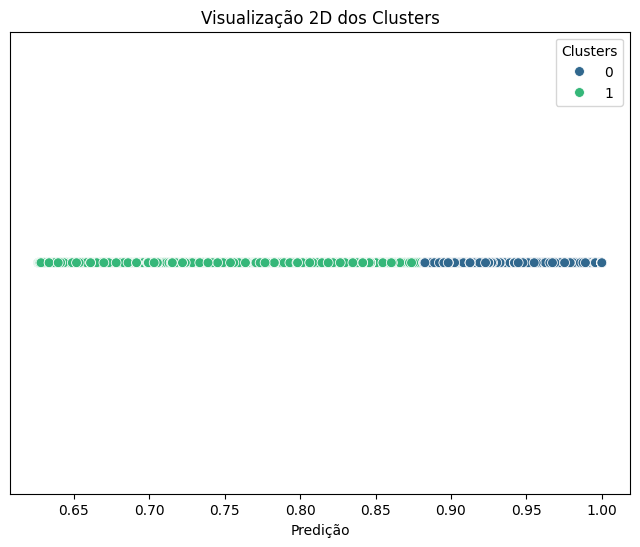

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='predicao', y=np.zeros(len(acima_do_limiar)), hue='cluster', data=acima_do_limiar, palette='viridis', s=50)

plt.gca().get_yaxis().set_visible(False)

plt.title('Visualização 2D dos Clusters')
plt.xlabel('Predição')
plt.legend(title='Clusters')
plt.show()


### ADICIONANDO RATING ACIMA DO LIMIAR

In [130]:
acima_do_limiar['rating'] = np.where(acima_do_limiar['cluster'] == 0, 'ALTISSIMA',
                                           np.where(acima_do_limiar['cluster'] == 1, 'ALTA', 'Outro'))
acima_do_limiar

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao,predicao_binaria,cluster,rating
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,1.0,1.0,0,1.0,1,0.999994,1,0,ALTISSIMA
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.0,1.0,1.0,0,1.0,1,0.999995,1,0,ALTISSIMA
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,54.0,32.00,1,SALA,BOA VISTA,0,...,0.0,1.0,1.0,17,1.0,1,0.999999,1,0,ALTISSIMA
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,31.0,53.00,1,SALA,BOA VISTA,0,...,0.0,1.0,1.0,17,1.0,1,0.999997,1,0,ALTISSIMA
38,0000b23be5378f1b8e79cf1867e8cc19,e7b87d7713fd44a490ecf5aaf6be6eb7,f4a09ae3e8291db3,2023.0,54.0,28.00,1,SALA,BOA VISTA,0,...,0.0,1.0,1.0,17,1.0,1,0.999999,1,0,ALTISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924005,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,13.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,0.0,1.0,1.0,0,1.0,1,0.999995,1,0,ALTISSIMA
1924012,ffff63826b501d84d8b209292c0ce31d,f307f8927e07ff0690ecf5aaf6be6eb7,e5ef9115acfa782e,2023.0,41.0,213.00,1,CASA,CORDEIRO,0,...,0.0,1.0,1.0,1,1.0,1,0.999994,1,0,ALTISSIMA
1924017,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,42.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,0.0,1.0,1.0,0,1.0,1,0.999984,1,0,ALTISSIMA
1924021,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,32.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,0.0,1.0,1.0,0,1.0,1,0.999993,1,0,ALTISSIMA


Definindo corte para BAIXISSIMA, BAIXA E MEDIA abaixo do limiar adotado

In [131]:
abaixo_do_limiar = df_resultado_predict.copy()
abaixo_do_limiar = abaixo_do_limiar.query('predicao < 0.626327')

In [132]:
from sklearn.cluster import KMeans

abaixo_do_limiar['cluster'] = 0

# Ajusta o K-Means com 3 clusters para dados abaixo do limiar usando a coluna 'predicao'
dados_abaixo_limiar = abaixo_do_limiar['predicao'].values.reshape(-1, 1)
kmeans_abaixo_limiar = KMeans(n_clusters=3, random_state=42)
abaixo_do_limiar['cluster'] = kmeans_abaixo_limiar.fit_predict(dados_abaixo_limiar)

Centroides abaixo do limiar

In [133]:
centroides_abaixo_limiar = abaixo_do_limiar.groupby('cluster')['predicao'].mean()
print("Centroides dos Clusters:")
pd.DataFrame(centroides_abaixo_limiar)

Centroides dos Clusters:


,predicao
cluster,
0,0.256808
1,0.034335
2,0.504050


In [147]:
centroides_abaixo_limiar = kmeans_abaixo_limiar.cluster_centers_
print("Centroides dos Clusters:")
for i, centroide in enumerate(centroides_abaixo_limiar):
    print(f"Cluster {i+0}: {centroide}")

Centroides dos Clusters:
Cluster 0: [0.25811553]
Cluster 1: [0.03459872]
Cluster 2: [0.5045771]


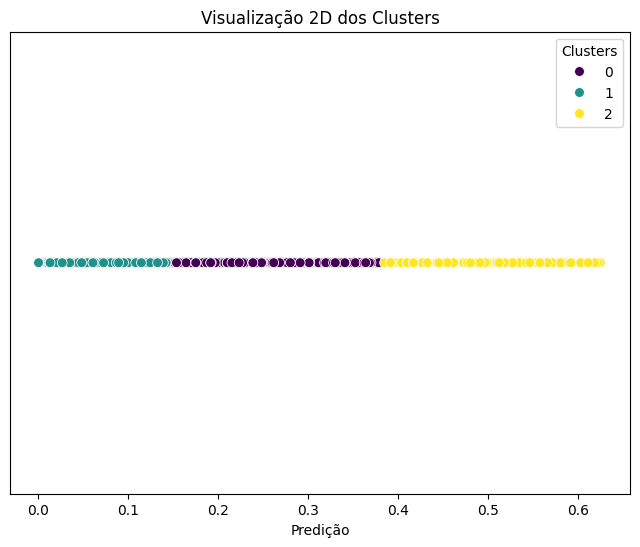

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='predicao', y=np.zeros(len(abaixo_do_limiar)), hue='cluster', data=abaixo_do_limiar, palette='viridis', s=50)

plt.gca().get_yaxis().set_visible(False)

# Configurações adicionais do gráfico
plt.title('Visualização 2D dos Clusters')
plt.xlabel('Predição')
plt.legend(title='Clusters')
plt.show()


### ADICIONANDO RATING ABAIXO DO LIMIAR

In [134]:
abaixo_do_limiar['rating'] = np.where(abaixo_do_limiar['cluster'] == 2, 'MEDIA',
                                      np.where(abaixo_do_limiar['cluster'] == 0, 'BAIXA',
                                               np.where(abaixo_do_limiar['cluster'] == 1, 'BAIXISSIMA', 'Outro')))
abaixo_do_limiar

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao,predicao_binaria,cluster,rating
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,56.0,110.15,1,CASA,AREIAS,1,...,0.600000,0.000000,1.0,1,0.215976,0,0.018225,0,1,BAIXISSIMA
46,00014b72ca2a255bd4613fe022d53698,20ebf87a9ba4e38090ecf5aaf6be6eb7,ab1890872c8b1262,2023.0,25.0,101.45,1,APARTAMENTO,CORDEIRO,0,...,0.000000,1.000000,1.0,0,0.988763,1,0.428725,0,2,MEDIA
52,00014b72ca2a255bd4613fe022d53698,b1c496061b8ce3d290ecf5aaf6be6eb7,a60c24f0ce2caa81,2023.0,38.0,89.80,1,APARTAMENTO,CORDEIRO,1,...,0.000000,0.774974,1.0,0,0.988763,0,0.300490,0,0,BAIXA
95,000473f4656786d9d4613fe022d53698,79fa28d80ba2d56290ecf5aaf6be6eb7,cabfecc5d23c6b25,2023.0,11.0,93.79,1,APARTAMENTO,BOA VIAGEM,0,...,0.600000,1.000000,1.0,0,0.165668,1,0.334544,0,0,BAIXA
101,000473f4656786d9d4613fe022d53698,a7c4990658a102d690ecf5aaf6be6eb7,2e037c9c5af02537,2023.0,21.0,138.48,1,APARTAMENTO,PARNAMIRIM,1,...,0.600000,0.000000,1.0,0,0.165668,0,0.312307,0,0,BAIXA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923891,fffafcbc80a2ab2a1603ecd7ff6be21f,86276918391d68af90ecf5aaf6be6eb7,c79c2476626fa4b6,2023.0,34.0,60.00,1,CASA,BREJO DA GUABIRABA,1,...,0.777778,0.000000,1.0,1,0.948412,0,0.491165,0,2,MEDIA
1923905,fffb82ff0c4ef8050246e2b93c1bf25c,49f07d673525777290ecf5aaf6be6eb7,263e230ea43a5599,2023.0,14.0,82.54,1,APARTAMENTO,TORRE,1,...,0.500000,0.000000,1.0,0,0.779606,0,0.330093,0,0,BAIXA
1923932,fffd0aa05b3e4fc40246e2b93c1bf25c,fa2c3a923b7b4b0e90ecf5aaf6be6eb7,15bdd971a7d7d41f,2023.0,16.0,534.63,1,EDIFICAÇÃO ESPECIAL,PINA,1,...,0.600000,0.000000,1.0,3,0.000000,0,0.000445,0,1,BAIXISSIMA
1923984,ffff083826a4e3f7d8b209292c0ce31d,3cae189ae394091390ecf5aaf6be6eb7,af63379fe7140354,2023.0,57.0,45.00,1,APARTAMENTO,BOA VIAGEM,0,...,0.800000,1.000000,1.0,0,0.707773,1,0.591825,0,2,MEDIA


### Unindo os dois dataframes e consolidando o rating

In [135]:
acima_do_limiar = acima_do_limiar.drop(columns=['cluster'])
abaixo_do_limiar = abaixo_do_limiar.drop(columns=['cluster'])

df_rating = pd.concat([acima_do_limiar, abaixo_do_limiar], ignore_index=True)
df_rating

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao,predicao_binaria,rating
0,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.000000,0.000000,1.0,1.0,0,1.000000,1,0.999994,1,ALTISSIMA
1,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.000000,1.0,1.0,0,1.000000,1,0.999995,1,ALTISSIMA
2,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,54.0,32.00,1,SALA,BOA VISTA,0,...,0.000000,0.000000,1.0,1.0,17,1.000000,1,0.999999,1,ALTISSIMA
3,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,31.0,53.00,1,SALA,BOA VISTA,0,...,0.000000,0.000000,1.0,1.0,17,1.000000,1,0.999997,1,ALTISSIMA
4,0000b23be5378f1b8e79cf1867e8cc19,e7b87d7713fd44a490ecf5aaf6be6eb7,f4a09ae3e8291db3,2023.0,54.0,28.00,1,SALA,BOA VISTA,0,...,0.000000,0.000000,1.0,1.0,17,1.000000,1,0.999999,1,ALTISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344209,fffafcbc80a2ab2a1603ecd7ff6be21f,86276918391d68af90ecf5aaf6be6eb7,c79c2476626fa4b6,2023.0,34.0,60.00,1,CASA,BREJO DA GUABIRABA,1,...,1.000000,0.777778,0.0,1.0,1,0.948412,0,0.491165,0,MEDIA
344210,fffb82ff0c4ef8050246e2b93c1bf25c,49f07d673525777290ecf5aaf6be6eb7,263e230ea43a5599,2023.0,14.0,82.54,1,APARTAMENTO,TORRE,1,...,0.285714,0.500000,0.0,1.0,0,0.779606,0,0.330093,0,BAIXA
344211,fffd0aa05b3e4fc40246e2b93c1bf25c,fa2c3a923b7b4b0e90ecf5aaf6be6eb7,15bdd971a7d7d41f,2023.0,16.0,534.63,1,EDIFICAÇÃO ESPECIAL,PINA,1,...,1.000000,0.600000,0.0,1.0,3,0.000000,0,0.000445,0,BAIXISSIMA
344212,ffff083826a4e3f7d8b209292c0ce31d,3cae189ae394091390ecf5aaf6be6eb7,af63379fe7140354,2023.0,57.0,45.00,1,APARTAMENTO,BOA VIAGEM,0,...,1.000000,0.800000,1.0,1.0,0,0.707773,1,0.591825,0,MEDIA


In [136]:
df_resultado_predict = df_rating.copy()

---

In [137]:
df_resultado_predict[['id_contribuinte', 'dam', 'id_imovel', 'ano',
                      'aberto','vlr_aberto', 'vlr_pago',
                      'perc_hist_pago', 'pagamento','percentual_pago', 'predicao', 'rating']]

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao,rating
0,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,0,0.00,1904.40,1.000000,1,1.0,0.999994,ALTISSIMA
1,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,0,0.00,3982.40,1.000000,1,1.0,0.999995,ALTISSIMA
2,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,0,0.00,351.48,1.000000,1,1.0,0.999999,ALTISSIMA
3,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,0,0.00,1066.80,1.000000,1,1.0,0.999997,ALTISSIMA
4,0000b23be5378f1b8e79cf1867e8cc19,e7b87d7713fd44a490ecf5aaf6be6eb7,f4a09ae3e8291db3,2023.0,0,0.00,290.64,1.000000,1,1.0,0.999999,ALTISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...
344209,fffafcbc80a2ab2a1603ecd7ff6be21f,86276918391d68af90ecf5aaf6be6eb7,c79c2476626fa4b6,2023.0,1,617.19,0.00,0.948412,0,0.0,0.491165,MEDIA
344210,fffb82ff0c4ef8050246e2b93c1bf25c,49f07d673525777290ecf5aaf6be6eb7,263e230ea43a5599,2023.0,1,1987.64,0.00,0.779606,0,0.0,0.330093,BAIXA
344211,fffd0aa05b3e4fc40246e2b93c1bf25c,fa2c3a923b7b4b0e90ecf5aaf6be6eb7,15bdd971a7d7d41f,2023.0,1,58245.71,0.00,0.000000,0,0.0,0.000445,BAIXISSIMA
344212,ffff083826a4e3f7d8b209292c0ce31d,3cae189ae394091390ecf5aaf6be6eb7,af63379fe7140354,2023.0,0,0.00,420.03,0.707773,1,1.0,0.591825,MEDIA


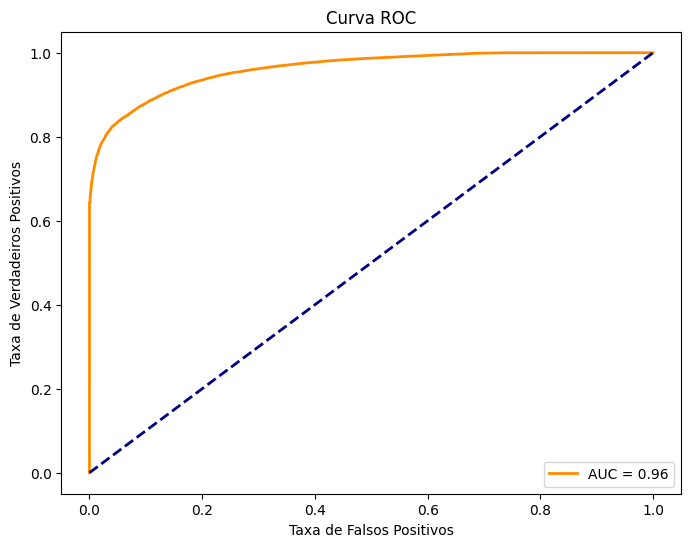

In [228]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(observado, predicao)

# Encontrar o índice do limiar mais próximo ao valor desejado
indice_limiar = (np.abs(thresholds - limiar)).argmin()
limiar_selecionado = thresholds[indice_limiar]
predicoes_binarias = (predicao >= limiar_selecionado).astype(int)

fpr, tpr, _ = roc_curve(observado, predicao)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

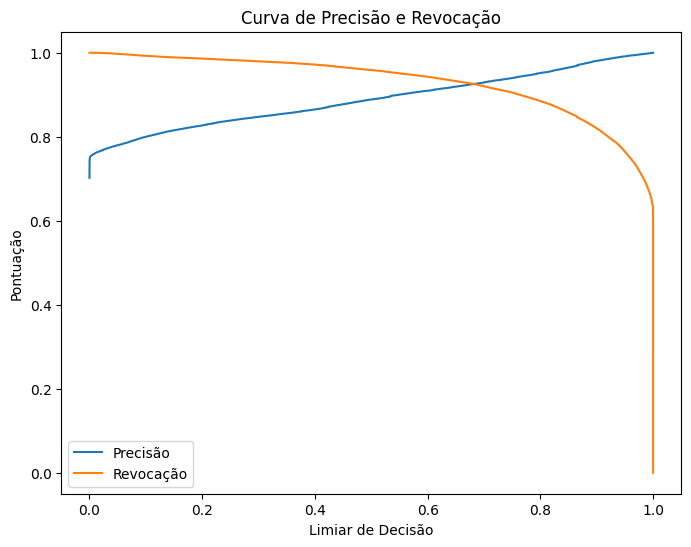

In [204]:
from sklearn.metrics import precision_recall_curve

precision, recall, limiar = precision_recall_curve(observado, predicao)

plt.figure(figsize=(8, 6))
plt.plot(limiar, precision[:-1], label='Precisão')
plt.plot(limiar, recall[:-1], label='Revocação')
plt.xlabel('Limiar de Decisão')
plt.ylabel('Pontuação')
plt.title('Curva de Precisão e Revocação')
plt.legend(loc='lower left')
plt.show()


### MATRIZ DE CONFUSÃO

In [312]:
conf_matrix = confusion_matrix(observado, predicoes_binarias)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,81374,21106
Real Positivo,15110,226624


### DISTRIBUIÇÃO PERCENTUAL DA MATRIZ DE CONFUSÃO

In [191]:
conf_matrix = confusion_matrix(observado, predicoes_binarias)
total_observacoes = len(observado)
conf_matrix_percentual = conf_matrix / total_observacoes * 100

rotulos_verdadeiros = ['Real Negativo', 'Real Positivo']
rotulos_previstos = ['Predito Negativo', 'Predito Positivo']

df_conf_matrix_percentual = pd.DataFrame(conf_matrix_percentual, index=rotulos_verdadeiros, columns=rotulos_previstos)
print("Matriz de Confusão em Percentual:")
df_conf_matrix_percentual

Matriz de Confusão em Percentual:


,Predito Negativo,Predito Positivo
Real Negativo,23.640526,6.131651
Real Positivo,4.389711,65.838112


### Corte em que o nosso f1-score é o melhor = 0.926009

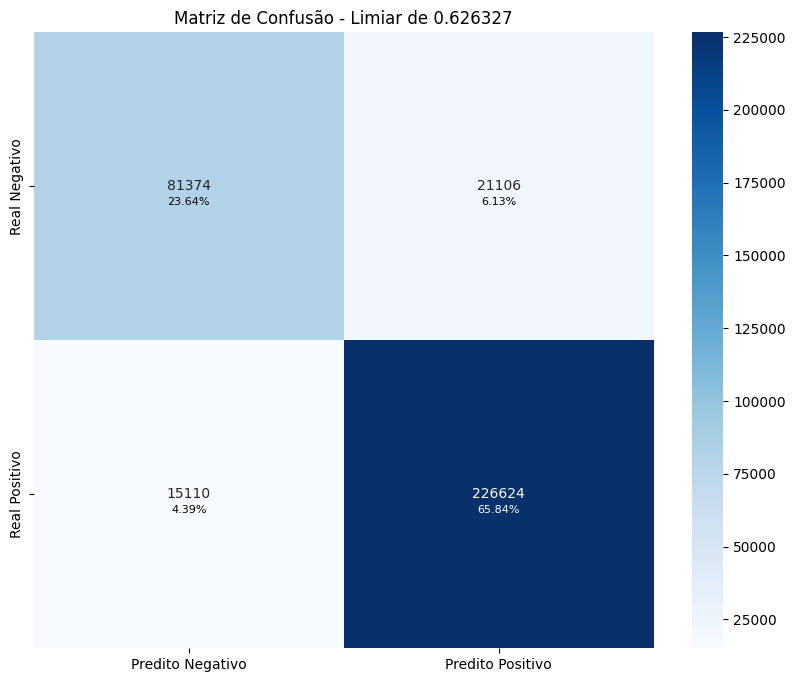

In [313]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - Limiar de {limiar}")

for i in range(df_conf_matrix.shape[0]):
    for j in range(df_conf_matrix.shape[1]):
        text = f'{df_conf_matrix_percentual.iloc[i, j]:.2f}%'
        color = 'black' if df_conf_matrix.iloc[i, j] < df_conf_matrix.values.max() / 2 else 'white'
        plt.text(j + 0.5, i + 0.5 + 0.05, text, ha='center', va='center', color=color, fontsize=8)
plt.show()

### Corte em que aumentamos os erros onde a pessoa paga e prevemos que ela não pagaria

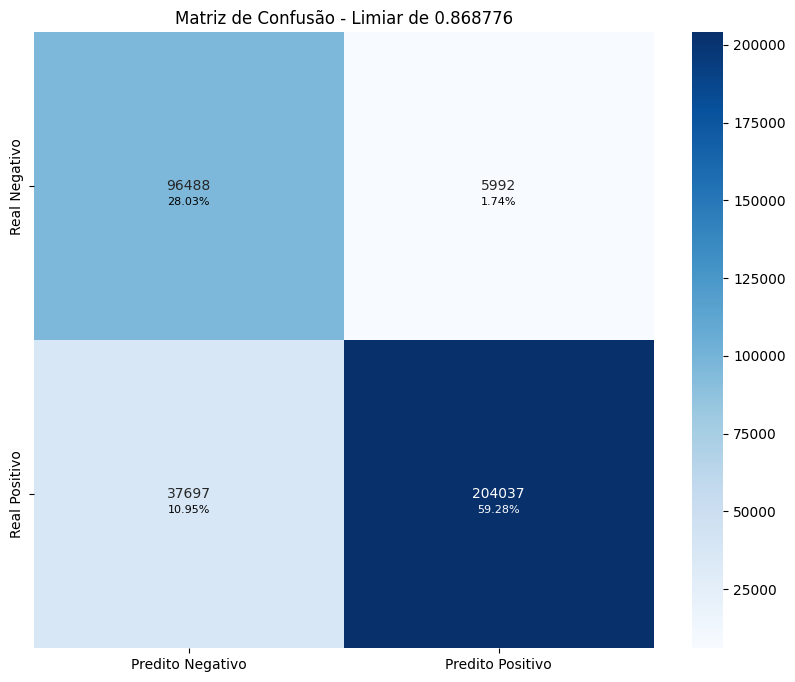

In [231]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - Limiar de {limiar}")

for i in range(df_conf_matrix.shape[0]):
    for j in range(df_conf_matrix.shape[1]):
        text = f'{df_conf_matrix_percentual.iloc[i, j]:.2f}%'
        color = 'black' if df_conf_matrix.iloc[i, j] < df_conf_matrix.values.max() / 2 else 'white'
        plt.text(j + 0.5, i + 0.5 + 0.05, text, ha='center', va='center', color=color, fontsize=8)
plt.show()

In [138]:
acuracia = accuracy_score(observado, predicoes_binarias)
roc_auc = roc_auc_score(observado, predicao)
precisao = precision_score(observado, predicoes_binarias)
revocacao = recall_score(observado, predicoes_binarias)
f1 = f1_score(observado, predicoes_binarias)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.8947863828897139
ROC AUC: 0.9619238735547457
Precisão: 0.9148024058450732
Revocação (Sensibilidade): 0.9374932777350311
F1 Score: 0.9260088586698919


# RESÍDUOS

In [139]:
df_resultado_predict.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'pagamento', 'predicao',
       'predicao_binaria', 'rating'],
      dtype='object')

In [144]:
resultado = df_resultado_predict.copy()
aberto = resultado.query('vlr_pago != vlr_lancado')
fechado = resultado.query('vlr_pago == vlr_lancado')

In [158]:
def categorizar_porte(row):
    tipo_propriedade = row['tipo_propriedade']
    area_construida = row['area_construida']
 
    if tipo_propriedade == 'APARTAMENTO':
        if area_construida <= 60:
            return 'PEQUENO'
        elif 60 < area_construida <= 100:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'CASA':
        if area_construida <= 100:
            return 'PEQUENO'
        elif 100 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'LOJA':
        if area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'GARAGEM COMERCIAL':
        if area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'GALPAO':
        if 200 < area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'SALA':
        if 20 <= area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 150:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    else:
        return 'INDEFINIDO'
aberto['tamanho_imovel'] = aberto.apply(categorizar_porte, axis=1)
aberto

C:\Users\Acer\AppData\Local\Temp\ipykernel_20700\2195418008.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aberto['tamanho_imovel'] = aberto.apply(categorizar_porte, axis=1)


,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao,predicao_binaria,rating,tamanho_imovel
6,0001de7df29f8e85cd124eb8021f7dca,01978e90d064ce5090ecf5aaf6be6eb7,46db76d53b87a4d8,2023.0,42.0,47.00,1,CASA,ALTO DO MANDU,1,...,0.500000,0.000000,1.0,1,0.830163,0,0.765670,1,ALTA,PEQUENO
7,0001de7df29f8e85cd124eb8021f7dca,0619ff80758de57790ecf5aaf6be6eb7,74c6887d5d9693b3,2023.0,42.0,45.00,1,CASA,ALTO DO MANDU,1,...,0.500000,0.000000,1.0,1,0.830163,0,0.765670,1,ALTA,PEQUENO
17,0006da85fadfdfc1cd124eb8021f7dca,8bd82fd8f8527bd290ecf5aaf6be6eb7,6ce687e38073e56d,2023.0,41.0,101.69,1,APARTAMENTO,PARNAMIRIM,1,...,0.750000,0.345050,1.0,0,0.506426,0,0.638890,1,ALTA,GRANDE
50,001170d6216c0f3e0246e2b93c1bf25c,782e57d2f0d9ad5c90ecf5aaf6be6eb7,cd837b3684988abb,2023.0,57.0,41.32,1,APARTAMENTO,BOA VISTA,1,...,0.666667,0.000000,1.0,0,0.880175,0,0.739928,1,ALTA,PEQUENO
54,0012a7fa6d4dff5ad8b209292c0ce31d,37d2fe4046d51bd490ecf5aaf6be6eb7,9be4b0123e3a88c1,2023.0,22.0,0.00,0,TERRENO,CAXANGA,1,...,0.000000,0.449637,1.0,19,0.868335,0,0.858442,1,ALTA,INDEFINIDO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344208,fff9325728d059d81603ecd7ff6be21f,b9777d55547bde3d90ecf5aaf6be6eb7,b3503af7cfe8182f,2023.0,41.0,71.47,1,APARTAMENTO,AREIAS,1,...,0.714286,0.000000,1.0,0,0.000000,0,0.000336,0,BAIXISSIMA,MEDIO
344209,fffafcbc80a2ab2a1603ecd7ff6be21f,86276918391d68af90ecf5aaf6be6eb7,c79c2476626fa4b6,2023.0,34.0,60.00,1,CASA,BREJO DA GUABIRABA,1,...,0.777778,0.000000,1.0,1,0.948412,0,0.491165,0,MEDIA,PEQUENO
344210,fffb82ff0c4ef8050246e2b93c1bf25c,49f07d673525777290ecf5aaf6be6eb7,263e230ea43a5599,2023.0,14.0,82.54,1,APARTAMENTO,TORRE,1,...,0.500000,0.000000,1.0,0,0.779606,0,0.330093,0,BAIXA,MEDIO
344211,fffd0aa05b3e4fc40246e2b93c1bf25c,fa2c3a923b7b4b0e90ecf5aaf6be6eb7,15bdd971a7d7d41f,2023.0,16.0,534.63,1,EDIFICAÇÃO ESPECIAL,PINA,1,...,0.600000,0.000000,1.0,3,0.000000,0,0.000445,0,BAIXISSIMA,INDEFINIDO


In [145]:
aberto.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro,rating
count,102480,102480,102480,102480,102480,102480
unique,71406,102480,102465,20,94,5
top,878ed023fa473bede000edc2a2086273,01978e90d064ce5090ecf5aaf6be6eb7,230e61a5850bd81a,APARTAMENTO,BOA VIAGEM,BAIXISSIMA
freq,1170,1,3,43243,12529,48011


In [146]:
limiar62 = fechado.groupby(['rating']).agg({
    'id_imovel': 'nunique',
    'dam': 'nunique',
    'vlr_pago': 'sum'
}).reset_index()

order = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
limiar62['rating'] = pd.Categorical(limiar62['rating'], categories=order, ordered=True)

limiar62 = limiar62.sort_values(by='rating')
limiar62.reset_index(drop=True, inplace=True)

limiar62['vlr_pago'] = limiar62['vlr_pago'].apply(formatar_moeda)
limiar62

,rating,id_imovel,dam,vlr_pago
0,BAIXISSIMA,2634,2634,"R$ 5.496.999,26"
1,BAIXA,3760,3761,"R$ 9.466.302,05"
2,MEDIA,8714,8715,"R$ 24.802.912,37"
3,ALTA,24766,24769,"R$ 79.775.086,40"
4,ALTISSIMA,201821,201855,"R$ 697.113.811,07"


In [202]:
residuos_pred = fechado.query('pagamento != predicao_binaria')
# residuos_pred = fechado.query('pagamento == predicao_binaria')
residuos_pred

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,vlr_lancado,pagamento,perc_hist_pago,pagamento,percentual_pago,predicao,predicao_binaria,rating
247731,00014b72ca2a255bd4613fe022d53698,20ebf87a9ba4e38090ecf5aaf6be6eb7,ab1890872c8b1262,2023.0,0,0.0,1657.00,1657.00,1,0.988763,1,1.0,0.428725,0,MEDIA
247733,000473f4656786d9d4613fe022d53698,79fa28d80ba2d56290ecf5aaf6be6eb7,cabfecc5d23c6b25,2023.0,0,0.0,349.97,349.97,1,0.165668,1,1.0,0.334544,0,BAIXA
247735,0004bd531fda61538e79cf1867e8cc19,b5222231f94b1ad990ecf5aaf6be6eb7,2c3036b2376c2db0,2023.0,0,0.0,1981.08,1981.08,1,0.916442,1,1.0,0.095930,0,BAIXISSIMA
247740,000777f57c8049368dd06342399984d9,7c39c6ca0cd480bc90ecf5aaf6be6eb7,bc3471350be601d8,2023.0,0,0.0,657.20,657.20,1,0.997733,1,1.0,0.020680,0,BAIXISSIMA
247747,000a8913b4e31d3d8e79cf1867e8cc19,f365a540a09f16e490ecf5aaf6be6eb7,71711296a8eaa8bb,2023.0,0,0.0,264.32,264.32,1,0.595292,1,1.0,0.204525,0,BAIXA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344164,ffd7d05f74336f5375234379af146d63,8599eae9c702e47490ecf5aaf6be6eb7,7f7bae73f6a06b5e,2023.0,0,0.0,22674.00,22674.00,1,0.649372,1,1.0,0.546300,0,MEDIA
344181,ffe7c931fa501929adaf8563a746964a,4cd098df9442e6ed90ecf5aaf6be6eb7,a8cfcc158d3239da,2023.0,0,0.0,958.84,958.84,1,0.408619,1,1.0,0.280253,0,BAIXA
344182,ffe84a305c155a3dd8b209292c0ce31d,4878546606b0108490ecf5aaf6be6eb7,6955eea0e9ea4c11,2023.0,0,0.0,541.14,541.14,1,0.419016,1,1.0,0.557600,0,MEDIA
344199,fff5cca302e832fdb611c7a529816b3d,bc3d56055a950f5390ecf5aaf6be6eb7,001c7e409ebd34be,2023.0,0,0.0,2287.91,2287.91,1,0.798473,1,1.0,0.363955,0,BAIXA


In [203]:
15110 / 226624 * 100

6.6674315165207565

In [159]:
aberto.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'pagamento', 'predicao',
       'predicao_binaria', 'rating', 'tamanho_imovel'],
      dtype='object')

In [212]:
limiar62_estoque = aberto.groupby(['rating']).agg({
    'id_imovel': 'nunique',
    'dam': 'nunique',
    'vlr_aberto': 'sum',
    'vlr_lancado': 'sum',
    'id_contribuinte': 'nunique'
}).reset_index()

order = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
limiar62_estoque['rating'] = pd.Categorical(limiar62_estoque['rating'], categories=order, ordered=True)

limiar62_estoque = limiar62_estoque.sort_values(by='rating')
limiar62_estoque.reset_index(drop=True, inplace=True)

# limiar62_estoque['vlr_aberto'] = limiar62_estoque['vlr_aberto'].apply(formatar_moeda)
limiar62_estoque['vlr_lancado'] = limiar62_estoque['vlr_lancado'].apply(formatar_moeda)
limiar62_estoque

,rating,id_imovel,dam,vlr_aberto,vlr_lancado,id_contribuinte
0,BAIXISSIMA,48004,48011,1.273643e+08,"R$ 134.073.245,98",41322
1,BAIXA,16691,16693,4.842098e+07,"R$ 54.542.433,12",12673
2,MEDIA,16670,16670,4.486481e+07,"R$ 50.896.103,44",9261
3,ALTA,15984,15988,3.936742e+07,"R$ 46.662.524,43",7323
4,ALTISSIMA,5116,5118,1.375859e+07,"R$ 17.574.433,95",2711


In [213]:
formatar_moeda(limiar62_estoque['vlr_aberto'].sum())

'R$ 273.776.099,93'

In [208]:
alti = aberto.query('rating == "BAIXISSIMA"')
alti = alti.query('natureza_imovel == 0') 
alti
# ['tipo_propriedade'].value_counts()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao,predicao_binaria,rating,tamanho_imovel
247760,0012468c364597420246e2b93c1bf25c,07c521e52c58109890ecf5aaf6be6eb7,14814b153d9e8c73,2023.0,43.0,0.0,0,TERRENO,DOIS UNIDOS,1,...,0.818182,0.0,1.0,19,0.0,0,0.000063,0,BAIXISSIMA,INDEFINIDO
247761,0012468c364597420246e2b93c1bf25c,0863160c5551f63d90ecf5aaf6be6eb7,061edf5275eda635,2023.0,43.0,0.0,0,TERRENO,DOIS UNIDOS,1,...,0.818182,0.0,1.0,19,0.0,0,0.000063,0,BAIXISSIMA,INDEFINIDO
247762,0012468c364597420246e2b93c1bf25c,12b63133d9fe94c990ecf5aaf6be6eb7,f4e1e55c26237c31,2023.0,43.0,0.0,0,TERRENO,DOIS UNIDOS,1,...,0.818182,0.0,1.0,19,0.0,0,0.000063,0,BAIXISSIMA,INDEFINIDO
247763,0012468c364597420246e2b93c1bf25c,1437915b5f45d15d90ecf5aaf6be6eb7,689234ef1e2b981c,2023.0,43.0,0.0,0,TERRENO,DOIS UNIDOS,1,...,0.818182,0.0,1.0,19,0.0,0,0.000063,0,BAIXISSIMA,INDEFINIDO
247764,0012468c364597420246e2b93c1bf25c,17e5506a2a30d40290ecf5aaf6be6eb7,30b0837eb18d2ec3,2023.0,43.0,0.0,0,TERRENO,DOIS UNIDOS,1,...,0.818182,0.0,1.0,19,0.0,0,0.000063,0,BAIXISSIMA,INDEFINIDO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344099,ffae699d4f818d307b6689decb15c5f0,ccdb50b12f4783c890ecf5aaf6be6eb7,d62cccba92b3700f,2023.0,54.0,0.0,0,TERRENO,CAJUEIRO,1,...,0.692308,0.0,0.0,19,0.0,0,0.002737,0,BAIXISSIMA,INDEFINIDO
344100,ffae699d4f818d307b6689decb15c5f0,e8f99ffc61895e3590ecf5aaf6be6eb7,c0eab46c4bfce53f,2023.0,54.0,0.0,0,TERRENO,CAJUEIRO,1,...,0.692308,0.0,0.0,19,0.0,0,0.002737,0,BAIXISSIMA,INDEFINIDO
344127,ffc2ec3f8a262108344d77602867ec09,117104586122c5ce90ecf5aaf6be6eb7,8b08efb440099d87,2023.0,25.0,0.0,0,TERRENO,MONTEIRO,1,...,0.818182,0.0,1.0,19,0.0,0,0.000057,0,BAIXISSIMA,INDEFINIDO
344161,ffd663f7a49caa700246e2b93c1bf25c,7122b63de9c7584190ecf5aaf6be6eb7,37631827cd463f43,2023.0,41.0,0.0,0,TERRENO,PORTO DA MADEIRA,1,...,0.800000,0.0,1.0,19,0.0,0,0.000028,0,BAIXISSIMA,INDEFINIDO


In [206]:
(15608/48011)*100

32.509216637853825

tipo_propriedade originais: ['CASA' 'APARTAMENTO' 'SALA' 'LOJA' 'TERRENO' 'GARAGEM COMERCIAL'
 'EDIFICAÇÃO ESPECIAL' 'GALPÃO' 'MOCAMBO' 'INDUSTRIA'
 'INSTITUIÇÃO EDUCACIONAL' 'INSTITUIÇÃO FINANCEIRA'
 'CENTRO COMERCIAL/SERVIÇOS' 'HOTEL' 'GALPÃO FECHADO' 'HOSPITAL'
 'TEMPLO RELIGIOSO' 'POSTO DE ABASTECIMENTO' 'LOJA MÚLTIPLA'
 'GARAGEM RESIDENCIAL']
tipo_propriedade codificados: [ 1  0 17 13 19  6  3  4 15 10 11 12  2  9  5  8 18 16 14  7]

## LIMIAR 62

### Este limiar (corte) é o melhor limiar onde eu equilibro meu modelo com a métrica f1-score nas duas diagonais

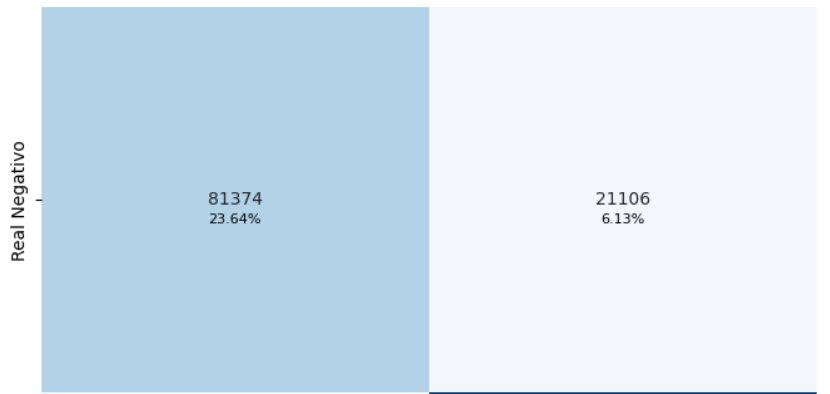

### Casos em que a pessoa deve e eu estou predizendo que ela vai pagar

In [205]:
limiar_66_aberto = pd.DataFrame()
limiar_66_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_66_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 1,'dam'].nunique()]
limiar_66_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_66_aberto['valor_predito_a_receber'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'vlr_aberto'].sum()]
limiar_66_aberto['percentual_a_arrecadar'] = (limiar_66_aberto['valor_predito_a_receber'] / limiar_66_aberto['valor_em_aberto']) * 100

limiar_66_aberto['valor_em_aberto'] = limiar_66_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_66_aberto['valor_predito_a_receber'] = limiar_66_aberto['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_receber,percentual_a_arrecadar
0,21100,21106,"R$ 273.776.099,93","R$ 53.126.011,24",19.404912


### Casos em que a pessoa deve e eu estou predizendo que ela não vai pagar

In [207]:
limiar_66_aberto = pd.DataFrame()
limiar_66_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_66_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 0,'dam'].nunique()]
limiar_66_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_66_aberto['valor_predito_a_receber'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'vlr_aberto'].sum()]
limiar_66_aberto['percentual'] = (limiar_66_aberto['valor_predito_a_receber'] / limiar_66_aberto['valor_em_aberto']) * 100

limiar_66_aberto['valor_em_aberto'] = limiar_66_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_66_aberto['valor_predito_a_receber'] = limiar_66_aberto['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_receber,percentual
0,81365,81374,"R$ 273.776.099,93","R$ 220.650.088,69",80.595088


### Este limiar (corte) faz com que venhamos predizer em casos onde a pessoa pagou eu dizer moderadamente que ela não vai pagar

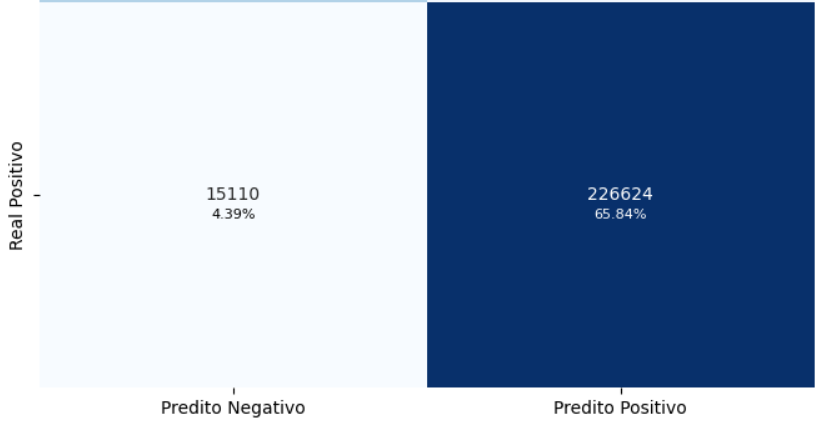

### Casos em que a pessoa pagou e eu estou predizendo que ela não vai pagar, ou seja, deixaria de receber

In [208]:
limiar_66_fechado = pd.DataFrame()
limiar_66_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_66_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'dam'].nunique()]
limiar_66_fechado['valor_total_pago'] = [fechado['vlr_pago'].sum()]
limiar_66_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'vlr_pago'].sum()]
limiar_66_fechado['percentual_a_arrecadar'] = (limiar_66_fechado['valor_predito_a_receber'] / limiar_66_fechado['valor_total_pago']) * 100

limiar_66_fechado['valor_total_pago'] = limiar_66_fechado['valor_total_pago'].apply(formatar_moeda)
limiar_66_fechado['valor_predito_a_receber'] = limiar_66_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_fechado

,imoveis,dams,valor_total_pago,valor_predito_a_receber,percentual_a_arrecadar
0,15108,15110,"R$ 816.655.111,15","R$ 39.766.213,68",4.869401


### Casos em que a pessoa pagou e eu estou predizendo que ela vai pagar

In [209]:
limiar_66_fechado = pd.DataFrame()
limiar_66_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_66_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'dam'].nunique()]
limiar_66_fechado['valor_total_pago'] = [fechado['vlr_pago'].sum()]
limiar_66_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'vlr_pago'].sum()]
limiar_66_fechado['percentual_a_arrecadar'] = (limiar_66_fechado['valor_predito_a_receber'] / limiar_66_fechado['valor_total_pago']) * 100

limiar_66_fechado['valor_total_pago'] = limiar_66_fechado['valor_total_pago'].apply(formatar_moeda)
limiar_66_fechado['valor_predito_a_receber'] = limiar_66_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_fechado

,imoveis,dams,valor_total_pago,valor_predito_a_receber,percentual_a_arrecadar
0,226587,226624,"R$ 816.655.111,15","R$ 776.888.897,47",95.130599


# LIMIAR 86

### Este limiar (corte) faz com que venhamos predizer em casos onde a dívida esta em aberto assumir que menos pessoas irão pagar

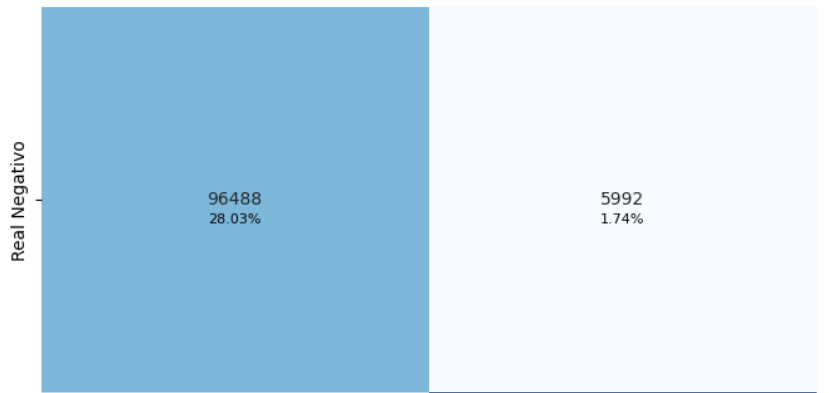

### Casos em que a pessoa deve e eu estou predizendo que ela vai pagar

In [238]:
limiar_84_aberto = pd.DataFrame()
limiar_84_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_84_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 1,'dam'].nunique()]
limiar_84_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_84_aberto['valor_predito_a_receber'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'vlr_aberto'].sum()]
limiar_84_aberto['percentual_a_arrecadar'] = (limiar_84_aberto['valor_predito_a_receber'] / limiar_84_aberto['valor_em_aberto']) * 100

limiar_84_aberto['valor_em_aberto'] = limiar_84_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_84_aberto['valor_predito_a_receber'] = limiar_84_aberto['valor_predito_a_receber'].apply(formatar_moeda)
limiar_84_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_receber,percentual_a_arrecadar
0,5989,5992,"R$ 273.776.099,93","R$ 15.955.418,07",5.827908


### Casos em que a pessoa deve e eu estou predizendo que ela não vai pagar

In [239]:
limiar_84_aberto = pd.DataFrame()
limiar_84_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_84_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 0,'dam'].nunique()]
limiar_84_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_84_aberto['valor_predito_a_NAO_receber'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'vlr_aberto'].sum()]
limiar_84_aberto['percentual'] = (limiar_84_aberto['valor_predito_a_NAO_receber'] / limiar_84_aberto['valor_em_aberto']) * 100

limiar_84_aberto['valor_em_aberto'] = limiar_84_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_84_aberto['valor_predito_a_NAO_receber'] = limiar_84_aberto['valor_predito_a_NAO_receber'].apply(formatar_moeda)
limiar_84_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_NAO_receber,percentual
0,96476,96488,"R$ 273.776.099,93","R$ 257.820.681,86",94.172092


### Este limiar (corte) faz com que venhamos predizer em casos onde a pessoa pagou eu dizer que ela não vai pagar

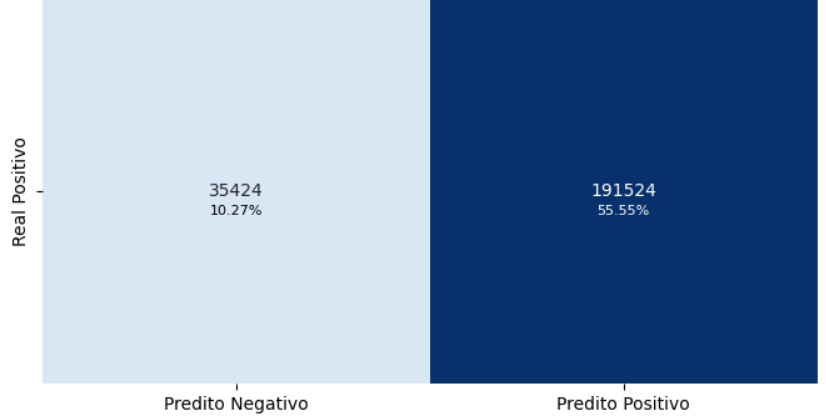

### Casos em que a pessoa pagou e eu estou predizendo que ela não vai pagar, ou seja, deixaria de receber

In [240]:
limiar_84_fechado = pd.DataFrame()
limiar_84_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_84_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 0,'dam'].nunique()]
limiar_84_fechado['valor_quitado'] = [fechado['vlr_pago'].sum()]
limiar_84_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'vlr_pago'].sum()]
limiar_84_fechado['percentual_a_arrecadar'] = (limiar_84_fechado['valor_predito_a_receber'] / limiar_84_fechado['valor_quitado']) * 100

limiar_84_fechado['valor_quitado'] = limiar_84_fechado['valor_quitado'].apply(formatar_moeda)
limiar_84_fechado['valor_predito_a_receber'] = limiar_84_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_84_fechado

,imoveis,dams,valor_quitado,valor_predito_a_receber,percentual_a_arrecadar
0,37693,37698,"R$ 816.655.111,15","R$ 111.136.709,64",13.608769


### Casos em que a pessoa pagou e eu estou predizendo que ela vai pagar

In [241]:
limiar_84_fechado = pd.DataFrame()
limiar_84_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_84_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 1,'dam'].nunique()]
limiar_84_fechado['valor_quitado'] = [fechado['vlr_pago'].sum()]
limiar_84_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'vlr_pago'].sum()]
limiar_84_fechado['percentual_a_arrecadar'] = (limiar_84_fechado['valor_predito_a_receber'] / limiar_84_fechado['valor_quitado']) * 100

limiar_84_fechado['valor_quitado'] = limiar_84_fechado['valor_quitado'].apply(formatar_moeda)
limiar_84_fechado['valor_predito_a_receber'] = limiar_84_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_84_fechado

,imoveis,dams,valor_quitado,valor_predito_a_receber,percentual_a_arrecadar
0,204002,204036,"R$ 816.655.111,15","R$ 705.518.401,51",86.391231


---

In [486]:
formatar_moeda(aberto['vlr_pago'].sum())

'R$ 722.444.399,29'

In [434]:
formatar_moeda(fechado['suposto_valor'].sum())

'R$ 81.532.674,20'

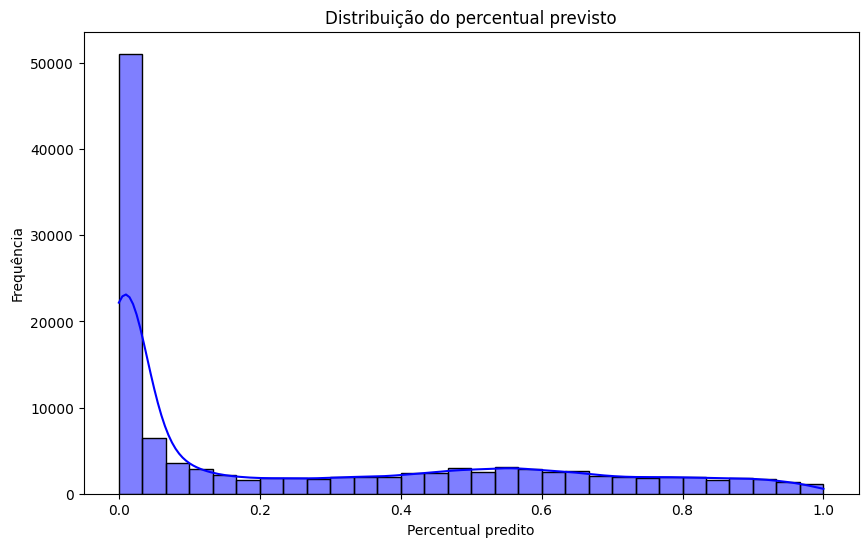

In [435]:
plt.figure(figsize=(10, 6))
sns.histplot(fechado['predicao'], kde=True, color='blue', bins=30)
plt.title('Distribuição do percentual previsto')
plt.xlabel('Percentual predito')
plt.ylabel('Frequência')
plt.show()

## Avaliação dos resíduos diferentes de 0 e 1 

In [125]:
fechado['residuos'] =  fechado['percentual_pago'] - fechado['predicao']
resid = fechado[['predicao', 'percentual_pago', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['predicao'] != 0]
resid_not0_not1 = resid_not0[resid_not0['predicao'] != 1]
resid_not0_not1 

,predicao,percentual_pago,residuos
371986,0.000150,1.0,0.999850
1090594,0.000488,1.0,0.999512
1160659,0.000594,1.0,0.999406
325407,0.001184,1.0,0.998816
1517289,0.001395,1.0,0.998605
...,...,...,...
301409,0.999998,1.0,0.000002
301389,0.999998,1.0,0.000002
301374,0.999998,1.0,0.000002
301029,0.999998,1.0,0.000002


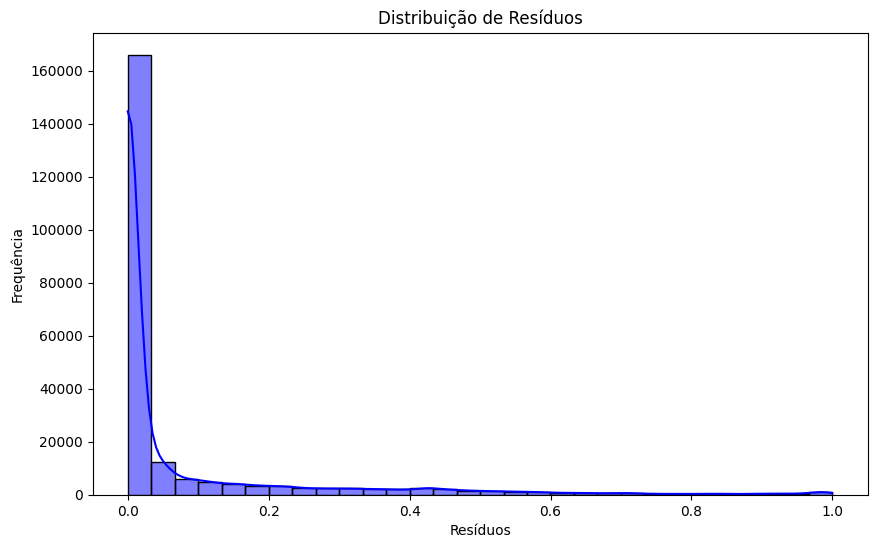

In [130]:
plt.figure(figsize=(10, 6))
sns.histplot(fechado['residuos'], kde=True, color='blue', bins=30)
plt.title('Distribuição de Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

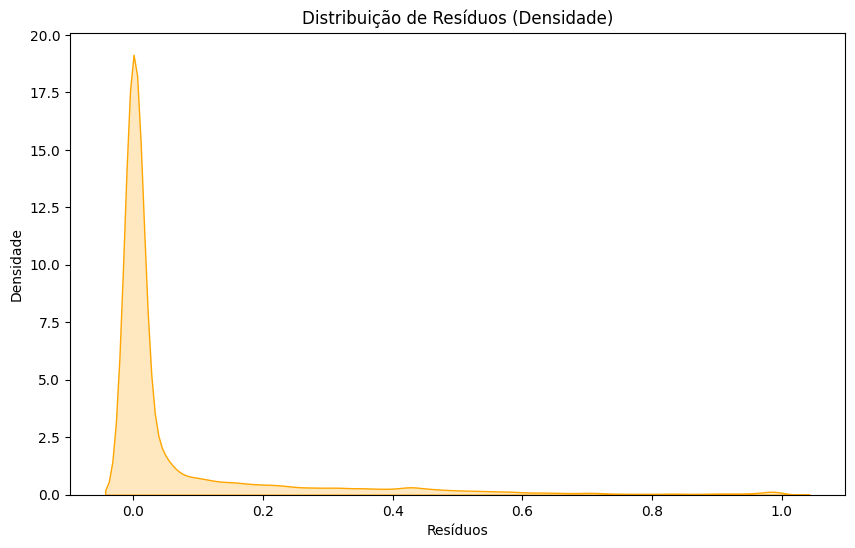

In [131]:
# Ou crie um gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(fechado['residuos'], fill=True, color='orange')
plt.title('Distribuição de Resíduos (Densidade)')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()


In [126]:
def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

data_percentil = {
    'inf': [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75],
    'sup': [-0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
}
[-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil

,inf,sup,intervalo
0,-1.00,-0.75,"[-1.0, -0.75)"
1,-0.75,-0.50,"[-0.75, -0.5)"
2,-0.50,-0.25,"[-0.5, -0.25)"
3,-0.25,-0.20,"[-0.25, -0.2)"
4,-0.20,-0.15,"[-0.2, -0.15)"
5,-0.15,-0.10,"[-0.15, -0.1)"
6,-0.10,-0.05,"[-0.1, -0.05)"
7,-0.05,0.00,"[-0.05, 0.0)"
8,0.00,0.05,"[0.0, 0.05)"
9,0.05,0.10,"[0.05, 0.1)"


In [127]:
# Define the bins and labels for groups
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
total = df_summary_residuos['resid_faixas'].sum()
df_summary_residuos['perc'] = np.round(df_summary_residuos['resid_faixas']/total, 5)
df_summary_residuos

,resid_faixas,perc
resid_faixas,,
"[-1.0, -0.75)",0,0.00000
"[-0.75, -0.5)",0,0.00000
"[-0.5, -0.25)",0,0.00000
"[-0.25, -0.2)",0,0.00000
"[-0.2, -0.15)",0,0.00000
"[-0.15, -0.1)",0,0.00000
"[-0.1, -0.05)",0,0.00000
"[-0.05, 0.0)",0,0.00000
"[0.0, 0.05)",173712,0.76543


In [128]:
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], bins=igr_bins, labels=igr_labels, right=False)

df_summary_residuos = resid.groupby('resid_faixas').agg(
    {'residuos': 'mean', 'percentual_pago': 'mean', 'resid_faixas': 'count'}
).rename(columns={'resid_faixas': 'frequencia'})

df_summary_residuos['perc'] = df_summary_residuos['frequencia'] / df_summary_residuos['frequencia'].sum() * 100
df_summary_residuos

,residuos,percentual_pago,frequencia,perc
resid_faixas,,,,
"[-1.0, -0.75)",NaN,NaN,0,0.000000
"[-0.75, -0.5)",NaN,NaN,0,0.000000
"[-0.5, -0.25)",NaN,NaN,0,0.000000
"[-0.25, -0.2)",NaN,NaN,0,0.000000
"[-0.2, -0.15)",NaN,NaN,0,0.000000
"[-0.15, -0.1)",NaN,NaN,0,0.000000
"[-0.1, -0.05)",NaN,NaN,0,0.000000
"[-0.05, 0.0)",NaN,NaN,0,0.000000
"[0.0, 0.05)",0.003727,1.0,173712,76.542644


In [123]:
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq,perc
0,"[-1.0, -0.75)",0,0.00000
1,"[-0.75, -0.5)",0,0.00000
2,"[-0.5, -0.25)",0,0.00000
3,"[-0.25, -0.2)",0,0.00000
4,"[-0.2, -0.15)",0,0.00000
5,"[-0.15, -0.1)",0,0.00000
6,"[-0.1, -0.05)",0,0.00000
7,"[-0.05, 0.0)",0,0.00000
8,"[0.0, 0.05)",173712,0.76543
9,"[0.05, 0.1)",10863,0.04787


In [129]:
residuos_faixa_erro = fechado.query('(residuos >= 0.75) & (residuos <= 1.0)')
# residuos_faixa_acerto = df_resultado_predict.query('(residuos >= 0.00) & (residuos <= 0.05)')
residuos_faixa_erro

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao,residuos
192,000777f57c8049368dd06342399984d9,7c39c6ca0cd480bc90ecf5aaf6be6eb7,bc3471350be601d8,2023.0,0,0.0,657.20,0.997733,1,1.0,0.007437,0.992563
255,000a8913b4e31d3d8e79cf1867e8cc19,f365a540a09f16e490ecf5aaf6be6eb7,71711296a8eaa8bb,2023.0,0,0.0,264.32,0.595292,1,1.0,0.094502,0.905498
1752,002997e93d88f909dd9a3cb674b9fb28,f32c4045a12788cb90ecf5aaf6be6eb7,24a29af8f3da6850,2023.0,0,0.0,4019.30,0.978841,1,1.0,0.016583,0.983417
2281,003d77b4d5acedcfcd124eb8021f7dca,144762e90b2ecd9790ecf5aaf6be6eb7,e9e5813660513601,2023.0,0,0.0,1430.10,0.609960,1,1.0,0.171076,0.828924
3623,007719db01137158ec24828071529570,cd58ecb5f4e1305690ecf5aaf6be6eb7,22a2b66ba2b6cdeb,2023.0,0,0.0,1471.30,0.975492,1,1.0,0.202907,0.797093
...,...,...,...,...,...,...,...,...,...,...,...,...
1920051,ff5a338d6b0d75cd9daa7b7dbb545c1c,249c68ff79a85d1590ecf5aaf6be6eb7,94054c7ea04851c0,2023.0,0,0.0,4485.79,0.979829,1,1.0,0.015675,0.984325
1920449,ff6804b40ae92ca8d8b209292c0ce31d,060b63d5a2d819f290ecf5aaf6be6eb7,bedd84876b363f35,2023.0,0,0.0,913.50,0.818445,1,1.0,0.183547,0.816453
1920586,ff6d015ffecc66f08e79cf1867e8cc19,045610abe0f9056090ecf5aaf6be6eb7,63996a8c5cfa2c8a,2023.0,0,0.0,330.39,0.455860,1,1.0,0.205902,0.794098
1920911,ff73d569207c0bec1172306dd24a62d3,8630975b13c7462090ecf5aaf6be6eb7,6e7cc7b0a23776f3,2023.0,0,0.0,1870.49,0.497761,1,1.0,0.124932,0.875068


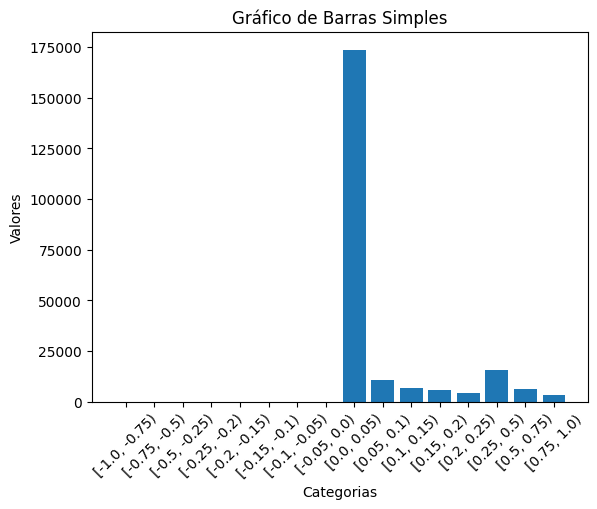

In [124]:
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']
plt.bar(categorias, valores)
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')
plt.xticks(rotation=45)
plt.show()

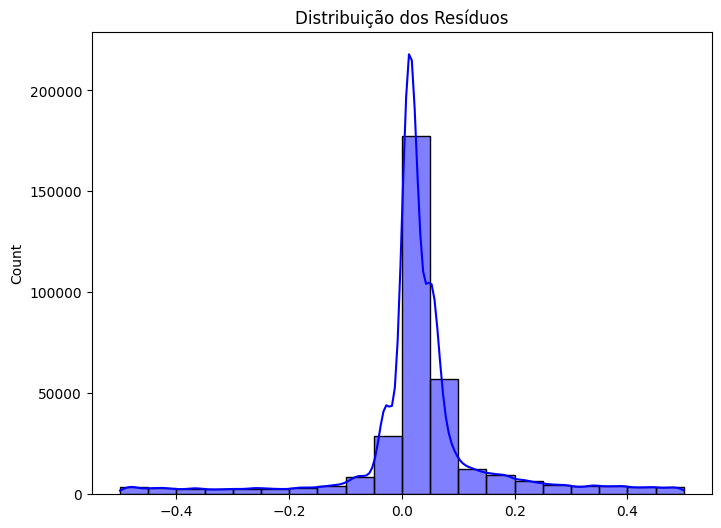

In [233]:
residuos = y_pred_test_23 - y_pred_proba_teste_23
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=20, kde=True, color='blue')
plt.title('Distribuição dos Resíduos')
plt.show()